# Problem Statement: 
####  Develop a model/system for aspect based sentiment analysis on the [Sentihood dataset](https://github.com/uclnlp/jack/tree/master/data/sentihood)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dense, Dropout, Flatten
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.layers import SpatialDropout1D, LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling2D,Reshape
from keras.models import Sequential
from keras import Model,Input
from keras.layers.convolutional import Conv1D
from keras.layers import Dense, Dropout, BatchNormalization, Input, Flatten, concatenate,Embedding
from keras.layers.recurrent import LSTM
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from keras.utils import np_utils

from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc


### Data loading
Source: https://github.com/HSLCY/ABSA-BERT-pair/blob/master/generate/data_utils_sentihood.py

In [ ]:
with open(r'/content/drive/My Drive/Colab Notebooks/sentihood_data/sentihood/sentihood-train.json') as f:
    data = json.load(f)
    for_df = []
    for d in data:
        text = d['text']
        sent_id = d['id']
        opinions = []
        targets = set()
        for opinion in d['opinions']:
            sentiment = opinion['sentiment']
            aspect = opinion['aspect']
            target_entity = opinion['target_entity']
            targets.add(target_entity)
            opinions.append((target_entity, aspect, sentiment))
        for_df.append((sent_id, text, opinions))
        
df=pd.DataFrame(for_df, columns=["id", "text", "sentiment"])
print("df shape from json: ", df.shape)
text_id=[]
text=[]
sentiments=[]
for i in range(len(df)):
    len_present=len(df['sentiment'][i])
    for j in range(len_present):
        text_id.append(df['id'][i])
        text.append(df['text'][i])
        sentiments.append(df['sentiment'][i][j])

train=pd.DataFrame({"id":text_id, "text":text, "sentiment":sentiments})
train['location']=train['sentiment'].apply(lambda x: x[0])
train['aspect']=train['sentiment'].apply(lambda x: x[1])
train['polarity']=train['sentiment'].apply(lambda x: x[2])
print("df shape after distinguishing dev set : ", train.shape)

with open(r'/content/drive/My Drive/Colab Notebooks/sentihood_data/sentihood/sentihood-dev.json') as f:
    data = json.load(f)
    for_df = []
    for d in data:
        text = d['text']
        sent_id = d['id']
        opinions = []
        targets = set()
        for opinion in d['opinions']:
            sentiment = opinion['sentiment']
            aspect = opinion['aspect']
            target_entity = opinion['target_entity']
            targets.add(target_entity)
            opinions.append((target_entity, aspect, sentiment))
        for_df.append((sent_id, text, opinions))
        
        
df=pd.DataFrame(for_df, columns=["id", "text", "sentiment"])

print("df shape from json: ", df.shape)

text_id=[]
text=[]
sentiments=[]
for i in range(len(df)):
    len_present=len(df['sentiment'][i])
    for j in range(len_present):
        text_id.append(df['id'][i])
        text.append(df['text'][i])
        sentiments.append(df['sentiment'][i][j])

dev=pd.DataFrame({"id":text_id, "text":text, "sentiment":sentiments})
dev['location']=dev['sentiment'].apply(lambda x: x[0])
dev['aspect']=dev['sentiment'].apply(lambda x: x[1])
dev['polarity']=dev['sentiment'].apply(lambda x: x[2])
print("df shape after distinguishing dev set : ", dev.shape)

with open(r'/content/drive/My Drive/Colab Notebooks/sentihood_data/sentihood/sentihood-test.json') as f:
    data = json.load(f)
    for_df = []
    for d in data:
        text = d['text']
        sent_id = d['id']
        opinions = []
        targets = set()
        for opinion in d['opinions']:
            sentiment = opinion['sentiment']
            aspect = opinion['aspect']
            target_entity = opinion['target_entity']
            targets.add(target_entity)
            opinions.append((target_entity, aspect, sentiment))
        for_df.append((sent_id, text, opinions))
        
        
df=pd.DataFrame(for_df, columns=["id", "text", "sentiment"])

print("df shape from json: ", df.shape)

text_id=[]
text=[]
sentiments=[]
for i in range(len(df)):
    len_present=len(df['sentiment'][i])
    for j in range(len_present):
        text_id.append(df['id'][i])
        text.append(df['text'][i])
        sentiments.append(df['sentiment'][i][j])

test=pd.DataFrame({"id":text_id, "text":text, "sentiment":sentiments})
test['location']=test['sentiment'].apply(lambda x: x[0])
test['aspect']=test['sentiment'].apply(lambda x: x[1])
test['polarity']=test['sentiment'].apply(lambda x: x[2])
print("df shape after distinguishing dev set : ", test.shape)

df shape from json:  (2977, 3)
df shape after distinguishing dev set :  (3396, 6)
df shape from json:  (747, 3)
df shape after distinguishing dev set :  (838, 6)
df shape from json:  (1491, 3)
df shape after distinguishing dev set :  (1677, 6)


## How is data present?
1. Every DataPoint has an Id, Text, Location, and aspect, sentiment and Target-Entity as part of opinion
2. Id and Text are unique for each Datapoint
3. There are 12 aspects namely 
      
            "general", "price", "transit-location","safety","live","nightlife","shopping","multicultural","green-nature","dining","quiet","touristy"
          
4. Sentiments can Either be Positive or Negative

5. Location Can be location1 or location2

Sources: EDA Notebook Attached

In [ ]:
train=train.drop("sentiment", axis=1)
dev=dev.drop("sentiment", axis=1)
test=test.drop("sentiment", axis=1)

In [ ]:
def handle_polarity(x):
  """ If Sentiment is +ve, return 1
      If Sentiment is -ve, return 0
  """
  if x=="Positive":
    return 1
  if x=="Negative":
    return 0

train['polarity']=train['polarity'].apply(handle_polarity)
dev['polarity']=dev['polarity'].apply(handle_polarity)
test['polarity']=test['polarity'].apply(handle_polarity)

In [ ]:
def handle_aspect(x):
  """
  Map the given aspects using a dict with key value pairs
  """
  aspect2idx={"general":0, "price":1,"transit-location":2,"safety":3,"live":4,"nightlife":5,
            "shopping":6,"multicultural":7,"green-nature":8,"dining":9,"quiet":10,"touristy":11}

  return aspect2idx[x]


### Map the Aspect Column using the key value pairs


train['aspect']=train['aspect'].apply(handle_aspect)
dev['aspect']=dev['aspect'].apply(handle_aspect)
test['aspect']=test['aspect'].apply(handle_aspect)

In [ ]:
data[0]

{'id': 153,
 'opinions': [{'aspect': 'safety',
   'sentiment': 'Positive',
   'target_entity': 'LOCATION1'}],
 'text': '   LOCATION1 is in Greater London  and is a very safe place'}

In [ ]:
train.head(10)

id                                               text  ... aspect  polarity
0  1430      LOCATION1 is transforming and the prices w...  ...      1         0
1  2013    Along LOCATION1 there are lots of Electronic...  ...      6         1
2  1244    And LOCATION1 is ten mins direct on the tube...  ...      2         1
3   209    Another option is LOCATION1 which is very ce...  ...      5         1
4   209    Another option is LOCATION1 which is very ce...  ...      2         1
5  2824    Best bet is around LOCATION2 and LOCATION1 a...  ...      0         1
6  2824    Best bet is around LOCATION2 and LOCATION1 a...  ...      0         1
7  1835    Central London based taxis mostly refuse far...  ...      2         0
8  1429    Don't go looking at places like LOCATION1  n...  ...      0         0
9  1429    Don't go looking at places like LOCATION1  n...  ...      4         0

[10 rows x 5 columns]

## Tokenization


1.   Use Tensorflow Inbuilt tokenizer to Tokenize text Data
2.   Fit it on train data and transform Validaton and Test Data on it
3.   Tackle Out-of-Vocabulary words using Unk Tags




In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['text'])
train_text = tokenizer.texts_to_sequences(train['text'])
dev_text = tokenizer.texts_to_sequences(dev['text'])
test_text = tokenizer.texts_to_sequences(test['text'])
len(tokenizer.word_index)

2732

## Padding


*   All Sentences have been padded to get a maximum length of 180
*   Sentences shorter than this length has been padded with 0

*   Sentences Larger Than this length has been clipped.
*   Since 180 is the 97th percentile of length of sentences.





In [ ]:
padded_train = pad_sequences(train_text,maxlen=180,padding='post', truncating='post')
padded_dev = pad_sequences(dev_text,maxlen=180,padding='post', truncating='post')
padded_test = pad_sequences(test_text,maxlen=180,padding='post', truncating='post')

## Text Embeddings

1. For our purpose, we have used GloVE Embeddings
2. We Store the Embeddings as a Key-Value pair and use the pre-trained weights in our Text Embeding Layer

In [ ]:
glove_pickel = open("/content/drive/My Drive/glove_vectors","rb")
glove_ = pickle.load(glove_pickel)
embedded = np.zeros((2733, 300))
for word, i in tokenizer.word_index.items():
    vector = glove_.get(word)
    if vector is not None:
        embedded[i] = vector
print("Shape of ", embedded.shape)

Shape of  (2733, 300)


## Plotting Functions
1. While model gets trained, It gives a history Parameter which we use to plot various metrics concerning us

In [ ]:
# https://stackoverflow.com/questions/52236996/how-to-avoid-overlapping-between-plot-titles-and-axis-titles-in-histogram-subplo
def plot_accuracy():
  plt.plot(history.history['out_aspect_accuracy'],'r-.+', label="Aspect Acc Train")   ## Training Accuracy for Aspect
  plt.plot(history.history['val_out_aspect_accuracy'],'g-.+', label="Aspect Acc Val")   ## Validation Accuracy for Aspect
  plt.plot(history.history['out_sentiment_accuracy'],"y",label=" Sentiment Acc train")  ## Training Accuracy for Sentiment
  plt.plot(history.history['val_out_sentiment_accuracy'],"m",label=" Sentiment Acc Val")   ## Validation Accuracy for Sentiment
  plt.legend()
  plt.title("Accuracy Scores Plot for Aspect and Sentiment")
  plt.ylabel('Accuracy Scores')
  plt.xlabel('Epoch Number')
  plt.tight_layout(pad = 0) 
  plt.show()

def plot_auc():  
  plt.plot(history.history['out_aspect_auc'],'r-.+', label="Aspect AUC Train")     ## Training AUC for Aspect
  plt.plot(history.history['val_out_aspect_auc'],'g-.+', label="Aspect AUC Val")   ## Validation AUC for Aspect
  plt.plot(history.history['out_sentiment_auc'],"y",label=" Sentiment AUC train")    ## Training AUC for Sentiment
  plt.plot(history.history['val_out_sentiment_auc'],"m",label=" Sentiment AUC Val")   ## Validation AUC for Sentiment
  plt.legend()
  plt.tight_layout(pad = 0) 
  plt.title("AUC Scores Plot for Aspect and Sentiment")
  plt.ylabel('AUC Scores')
  plt.xlabel('Epoch Number')
  plt.show()

def sentiment_confusion():
  sentiment_1=[0, 1]
  data = confusion_matrix(np.argmax(y_test_sentiment, axis=1), np.argmax(test_result_sentiment, axis=1))     ## Confusion Matrix 
  df_cm = pd.DataFrame(data, columns=sentiment_1, index = sentiment_1)
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  plt.figure(figsize = (12,10))
  sns.set(font_scale=1.4)#for label size
  sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='.01f')# font size
  plt.title("Confusion Matrix for Sentiments")
  plt.tight_layout(pad = 0) 
  plt.show()

def aspect_confusion():
  aspects_1=['general', 'price', 'transit-location', 'safety', 'live', 'nightlife', 'shopping','multicultural', 'green-nature', 'dining', 'quiet', 'touristy']
  data = confusion_matrix(np.argmax(y_test_aspect, axis=1), np.argmax(test_result_aspect, axis=1))
  df_cm = pd.DataFrame(data, columns=aspects_1, index = aspects_1)
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  plt.figure(figsize = (12,10))
  sns.set(font_scale=1.4)#for label size
  sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='.01f')# font size
  plt.title("Confusion Matrix for Aspects")
  plt.tight_layout(pad = 0) 
  plt.show()
def essentials():
  preds_test=model.predict(test_req_x )
  preds_val=model.predict(val_req_x )
  preds_train=model.predict(train_req_x )
  test_result_aspect=preds_test[0]
  test_result_sentiment=preds_test[1]
  train_result_aspect=preds_train[0]
  train_result_sentiment=preds_train[1]
  val_result_aspect=preds_val[0]
  val_result_sentiment=preds_val[1]
  return preds_test, preds_val, preds_train, test_result_aspect, test_result_sentiment

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)  ## Confuion Matrix
    A =(((C.T)/(C.sum(axis=1))).T)      ## Recall Matrix
    B =(C/C.sum(axis=0))                ## Precision Matrix

    ## Calculating F1 score

    numerator=np.multiply(A, B)  ## numerator term of F1 score
    numerator=np.multiply(2, numerator)    ## numerator term of F1 score
    deno=np.add(A,B)                      ## denominator term of F1 score
    req_f1=numerator/deno    
    plt.figure(figsize = (12,10)) 
    aspects_1=['general', 'price', 'transit-location', 'safety', 'live', 'nightlife', 'shopping','multicultural', 'green-nature', 'dining', 'quiet', 'touristy']    
    labels = aspects_1
    # representing A in heatmap format
    cmap=sns.light_palette("green")
    # plt.subplot(1, 3, 1)
    sns.heatmap(req_f1, annot=True, cmap=cmap, fmt=".2f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix of F1 Scores") 
    # plt.axis("off") 
    plt.tight_layout(pad = 0)   
    plt.show()

def calculate_f1():
  preds_test=model.predict(test_req_x )
  preds_val=model.predict(val_req_x )
  preds_train=model.predict(train_req_x )
  test_result_aspect=preds_test[0]
  test_result_sentiment=preds_test[1]
  train_result_aspect=preds_train[0]
  train_result_sentiment=preds_train[1]
  val_result_aspect=preds_val[0]
  val_result_sentiment=preds_val[1]
  print("-"*20, "Sentiment", "-"*20)
  print("train Sentiment F1 : ", f1_score(y_train_sentiment, train_result_sentiment.round(), average='micro'))
  print("val Sentiment F1 : ", f1_score(y_val_sentiment, val_result_sentiment.round(), average='micro'))
  print("Test Sentiment F1 : ", f1_score(y_test_sentiment, test_result_sentiment.round(), average='micro'))
  print("-"*20, "Aspect", "-"*20)
  print("train Aspect F1 : ", f1_score(y_train_aspect, train_result_aspect.round(), average='micro'))
  print("val Aspect F1 : ", f1_score(y_val_aspect, val_result_aspect.round(), average='micro'))
  print("Test Aspect F1 : ", f1_score(y_test_aspect, test_result_aspect.round(), average='micro'))
  
def analyse_all():
  
  # plt.axis("off") 
  plt.tight_layout(pad = 0) 
  print("-*-"*30)
  calculate_f1()
  print("-*-"*30)
  plot_accuracy()
  print("-*-"*30)
  plot_auc()
  print("-*-"*30)
  sentiment_confusion()
  print("-*-"*30)
  aspect_confusion()
  print("-*-"*30)
  plot_confusion_matrix(np.argmax(y_test_aspect, axis=1), np.argmax(test_result_aspect, axis=1))
  


In [ ]:
test.columns

Index(['id', 'text', 'location', 'aspect', 'polarity'], dtype='object')

In [ ]:
test['polarity'].value_counts()

1    1215
0     462
Name: polarity, dtype: int64

## Handling Labels
1. Aspect and Sentiment Labels are converted to Categorical Variables 

In [ ]:
## Taking the polarity of Sentiments

y_train_sentiment=train['polarity']
y_val_sentiment=dev['polarity']
y_test_sentiment=test['polarity']

## Converting Sentiments to Categorical Variables

y_train_sentiment= np_utils.to_categorical(y_train_sentiment, 2)
y_val_sentiment = np_utils.to_categorical(y_val_sentiment, 2)
y_test_sentiment = np_utils.to_categorical(y_test_sentiment, 2)

## Taking the Aspect of Sentiments

y_train_aspect=train['aspect']
y_val_aspect=dev['aspect']
y_test_aspect=test['aspect']

## Converting Aspects to Categorical Variables

y_train_aspect = np_utils.to_categorical(y_train_aspect, 12)
y_val_aspect = np_utils.to_categorical(y_val_aspect, 12)
y_test_aspect = np_utils.to_categorical(y_test_aspect, 12)


## Handling Location Masks

In [ ]:
## Label Encoding Locations using categorical Variables

le_location = preprocessing.LabelEncoder()
le_location_train=le_location.fit_transform(train["location"])
le_location_dev=le_location.transform(dev["location"])
le_location_test=le_location.transform(test["location"])


## Concating Location and Text features


In [ ]:
train_req_x=[padded_train,  le_location_train]
val_req_x=[padded_dev,  le_location_dev]
test_req_x=[padded_test, le_location_test]

## Model 1

Note: All the models have been compared at the end of this Notebook

In [ ]:
embedded_layer = Embedding(2733,300,weights=[embedded],input_length=180,trainable=False)

input_text = Input(shape=(180,),name="input_text")
x_1 = embedded_layer(input_text)
# x_1 = LSTM(128, return_sequences=True)(x_1)
x_1=Bidirectional(LSTM(128, return_sequences=True))(x_1)
flat_text = Flatten()(x_1)

input_location = Input(shape=(1,),name= "location")
layer_location = Embedding(2,1,trainable=False)(input_location)
flat_location = Flatten()(layer_location)

model = concatenate([flat_text ,flat_location])
# https://stackoverflow.com/questions/55181044/keras-custom-layer-valueerror-an-operation-has-none-for-gradient
model = Dense(32,activation="relu",kernel_initializer="he_uniform")(model)
model = Dropout(0.5)(model)

outputs_aspect = Dense(12, activation='softmax', name="out_aspect")(model)   
outputs_sentiment = Dense(2, activation='softmax', name="out_sentiment")(model)

model = Model(inputs = [input_text , input_location  ],outputs=[outputs_aspect, outputs_sentiment])

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy', tf.keras.metrics.AUC()])

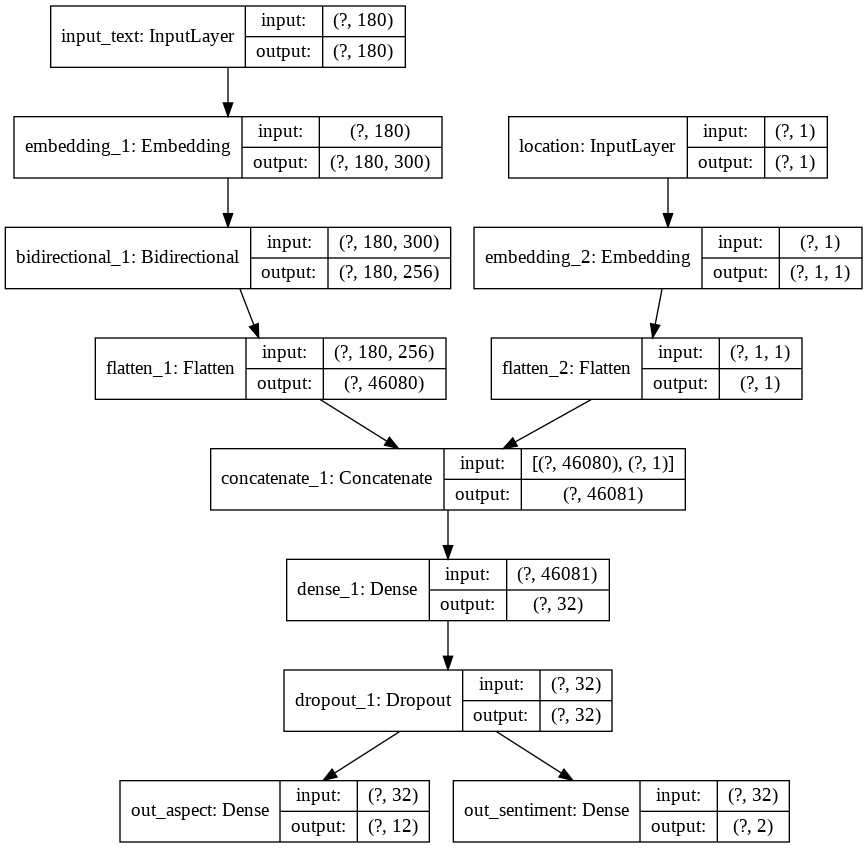

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model_1.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
checkpoint_filepath = '/tmp/checkpoint_1'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', save_best_only=True)

es=EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history=model.fit(train_req_x,{"out_aspect":y_train_aspect, "out_sentiment":y_train_sentiment}, 
                  validation_data=(val_req_x,{"out_aspect":y_val_aspect, "out_sentiment":y_val_sentiment}),
                  batch_size=128,epochs=40,verbose=1, callbacks=[model_checkpoint_callback, es])


Train on 3396 samples, validate on 838 samples
Epoch 1/40
3396/3396 [==============================] - 17s 5ms/step - loss: 2.8288 - out_aspect_loss: 2.2229 - out_sentiment_loss: 0.6030 - out_aspect_accuracy: 0.2874 - out_aspect_auc: 0.7847 - out_sentiment_accuracy: 0.6799 - out_sentiment_auc: 0.7965 - val_loss: 2.5050 - val_out_aspect_loss: 2.0237 - val_out_sentiment_loss: 0.4897 - val_out_aspect_accuracy: 0.3532 - val_out_aspect_auc: 0.8199 - val_out_sentiment_accuracy: 0.7554 - val_out_sentiment_auc: 0.8212
Epoch 2/40
3396/3396 [==============================] - 15s 4ms/step - loss: 2.4536 - out_aspect_loss: 1.9145 - out_sentiment_loss: 0.5384 - out_aspect_accuracy: 0.3804 - out_aspect_auc: 0.8354 - out_sentiment_accuracy: 0.7285 - out_sentiment_auc: 0.8360 - val_loss: 2.1678 - val_out_aspect_loss: 1.7053 - val_out_sentiment_loss: 0.4725 - val_out_aspect_accuracy: 0.4654 - val_out_aspect_auc: 0.8492 - val_out_sentiment_accuracy: 0.7625 - val_out_sentiment_auc: 0.8491
Epoch 3/40
3396

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
-------------------- Sentiment --------------------
train Sentiment F1 :  0.8916372202591284
val Sentiment F1 :  0.8126491646778043
Test Sentiment F1 :  0.7948717948717948
-------------------- Aspect --------------------
train Aspect F1 :  0.6812379786675993
val Aspect F1 :  0.6086330935251799
Test Aspect F1 :  0.5843503230437904
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


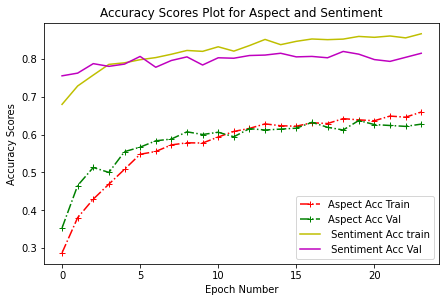

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


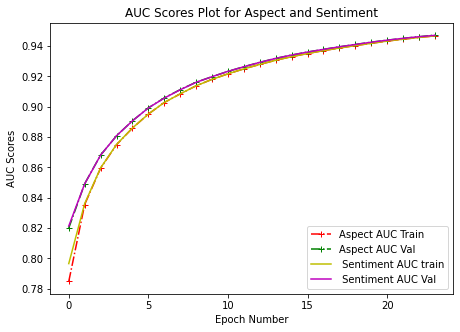

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


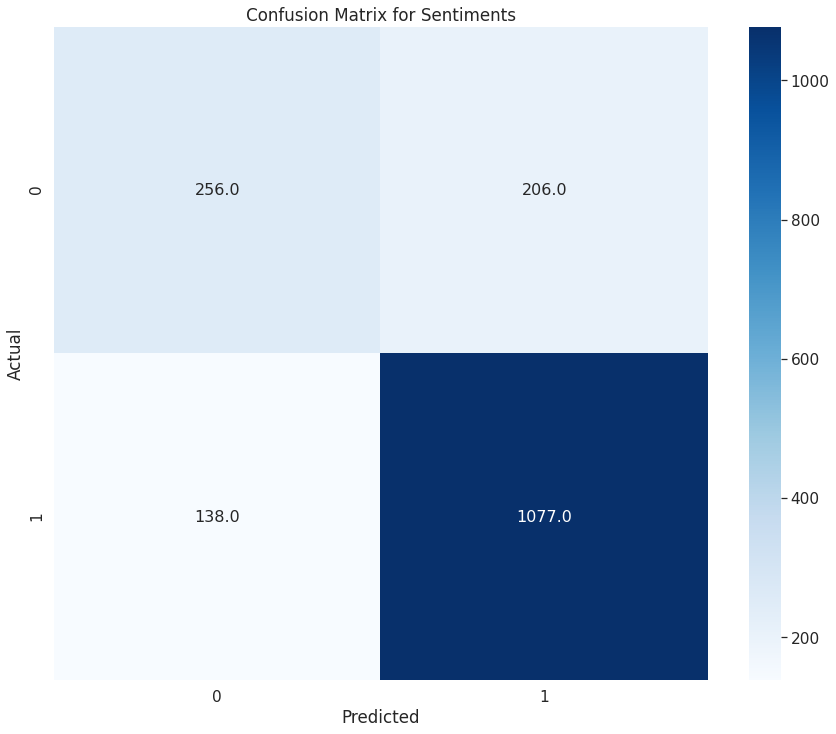

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


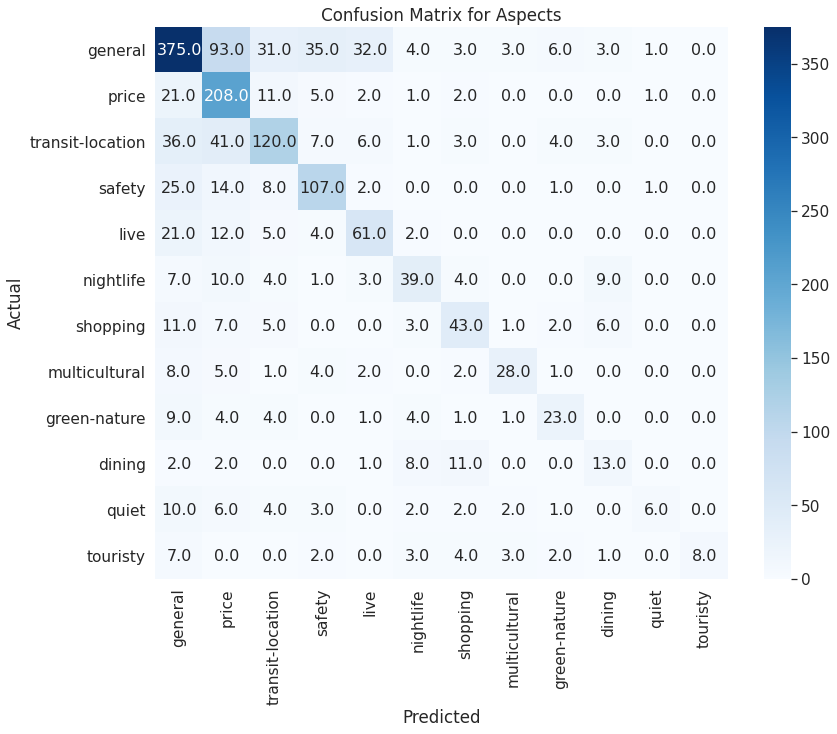

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide


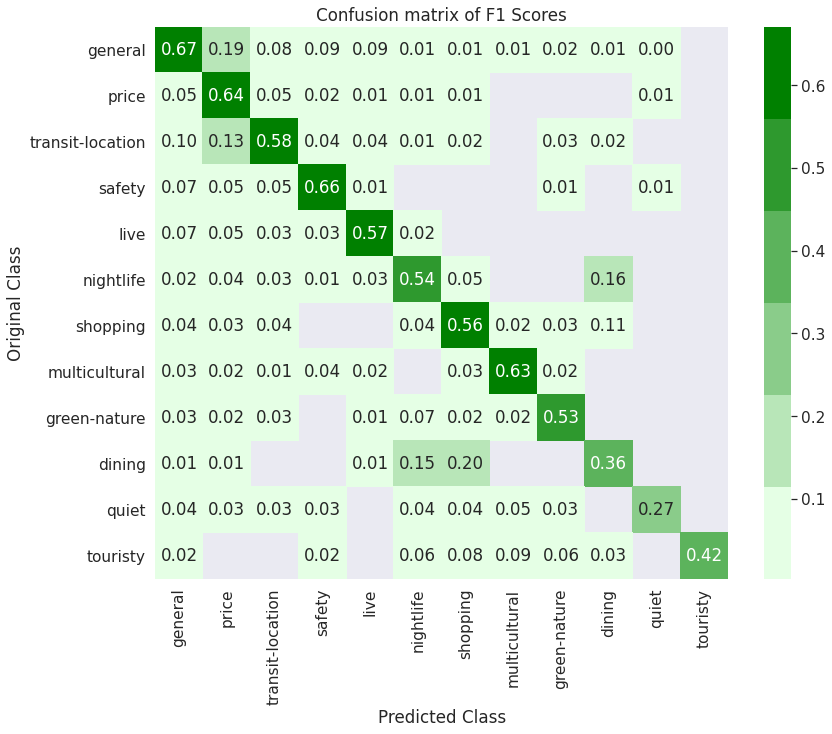

In [ ]:
preds_test, preds_val, preds_train, test_result_aspect, test_result_sentiment=essentials()
analyse_all()

## Model 2

In [ ]:
tf.keras.backend.clear_session()
embedded_layer = Embedding(2733,300,weights=[embedded],input_length=180,trainable=False)

input_text = Input(shape=(180,),name="input_text")
x_1 = embedded_layer(input_text)
# x_1 = LSTM(128, return_sequences=True)(x_1)
x_1=Bidirectional(LSTM(256, return_sequences=True))(x_1)
flat_text = Flatten()(x_1)

input_location = Input(shape=(1,),name= "location")
layer_location = Embedding(2,1,trainable=False)(input_location)
flat_location = Flatten()(layer_location)

model = concatenate([flat_text ,flat_location])
# https://stackoverflow.com/questions/55181044/keras-custom-layer-valueerror-an-operation-has-none-for-gradient
model = Dense(32,activation="relu",kernel_initializer="he_uniform")(model)
model = Dropout(0.5)(model)

outputs_aspect = Dense(12, activation='softmax', name="out_aspect")(model)   
outputs_sentiment = Dense(2, activation='softmax', name="out_sentiment")(model)

model = Model(inputs = [input_text , input_location  ],outputs=[outputs_aspect, outputs_sentiment])

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy', tf.keras.metrics.AUC()])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text (InputLayer)         (None, 180)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 180, 300)     819900      input_text[0][0]                 
__________________________________________________________________________________________________
location (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 180, 512)     1140736     embedding_1[0][0]                
____________________________________________________________________________________________

In [ ]:
checkpoint_filepath = '/tmp/checkpoint_2'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', save_best_only=True)

es=EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history=model.fit(train_req_x,{"out_aspect":y_train_aspect, "out_sentiment":y_train_sentiment}, 
                  validation_data=(val_req_x,{"out_aspect":y_val_aspect, "out_sentiment":y_val_sentiment}),
                  batch_size=128,epochs=40,verbose=1, callbacks=[model_checkpoint_callback, es])


Train on 3396 samples, validate on 838 samples
Epoch 1/40
3396/3396 [==============================] - 25s 7ms/step - loss: 2.8929 - out_aspect_loss: 2.2800 - out_sentiment_loss: 0.6106 - out_aspect_accuracy: 0.2335 - out_aspect_auc: 0.7672 - out_sentiment_accuracy: 0.6684 - out_sentiment_auc: 0.7838 - val_loss: 2.5168 - val_out_aspect_loss: 1.9851 - val_out_sentiment_loss: 0.5370 - val_out_aspect_accuracy: 0.3974 - val_out_aspect_auc: 0.8167 - val_out_sentiment_accuracy: 0.7506 - val_out_sentiment_auc: 0.8164
Epoch 2/40
3396/3396 [==============================] - 24s 7ms/step - loss: 2.4771 - out_aspect_loss: 1.9490 - out_sentiment_loss: 0.5270 - out_aspect_accuracy: 0.3625 - out_aspect_auc: 0.8326 - out_sentiment_accuracy: 0.7244 - out_sentiment_auc: 0.8331 - val_loss: 2.1494 - val_out_aspect_loss: 1.6952 - val_out_sentiment_loss: 0.4607 - val_out_aspect_accuracy: 0.4857 - val_out_aspect_auc: 0.8471 - val_out_sentiment_accuracy: 0.7673 - val_out_sentiment_auc: 0.8473
Epoch 3/40
3396

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
-------------------- Sentiment --------------------
train Sentiment F1 :  0.8745583038869258
val Sentiment F1 :  0.8090692124105012
Test Sentiment F1 :  0.7948717948717948
-------------------- Aspect --------------------
train Aspect F1 :  0.668075365381229
val Aspect F1 :  0.5903527717782577
Test Aspect F1 :  0.5743994263176766
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


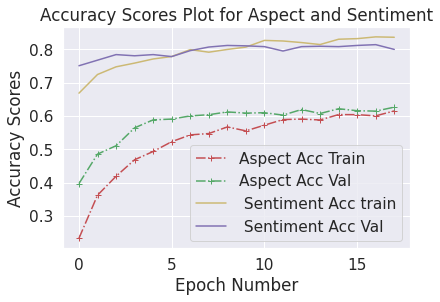

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


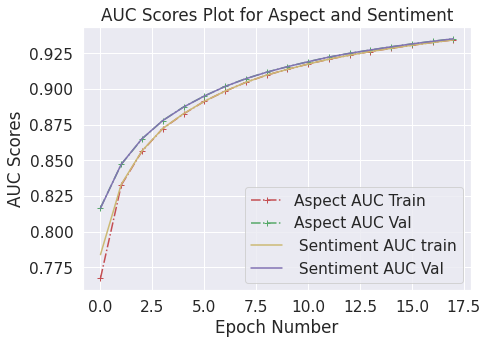

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


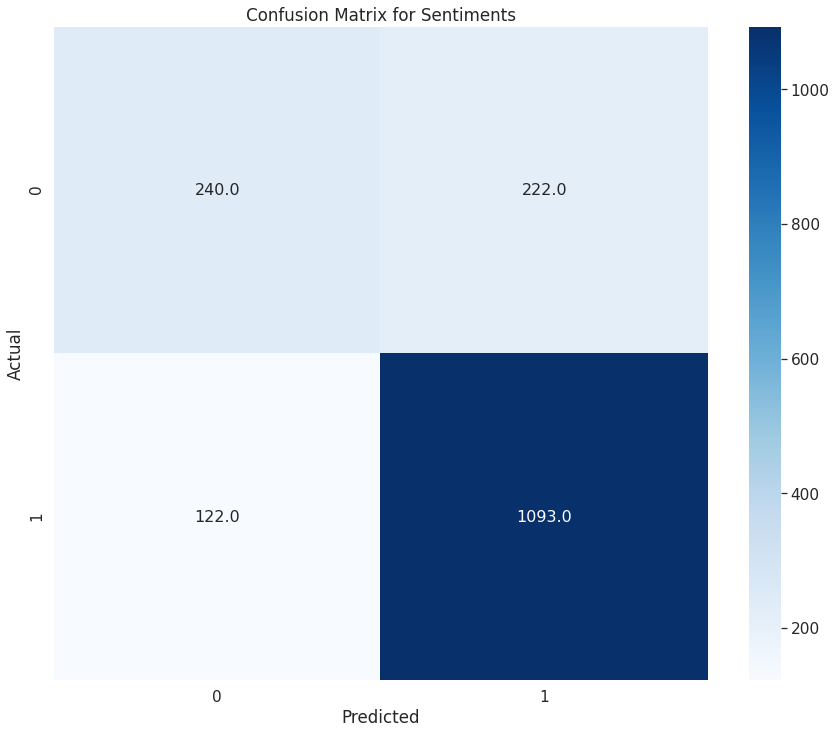

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


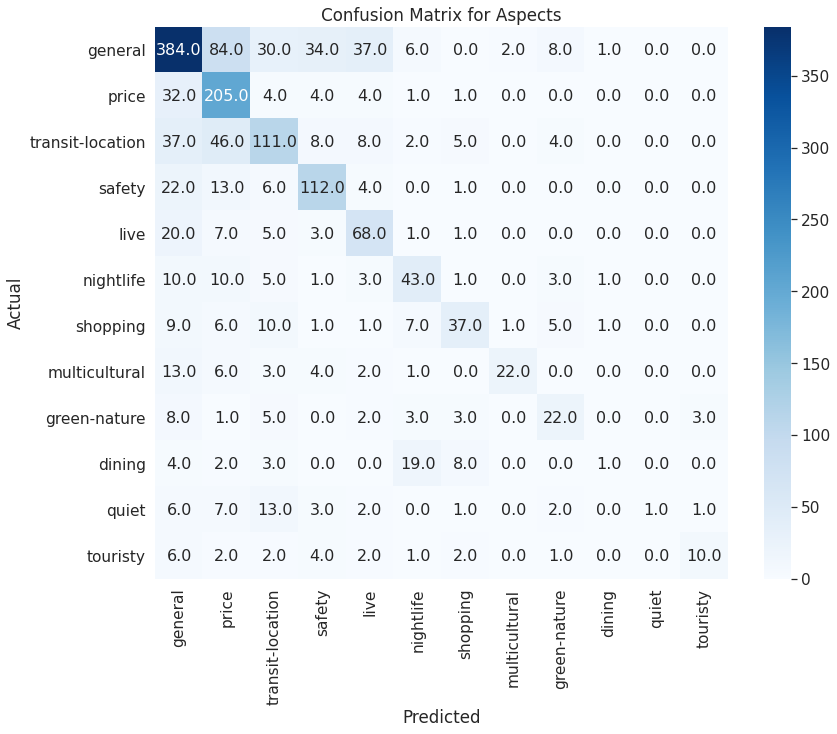

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide


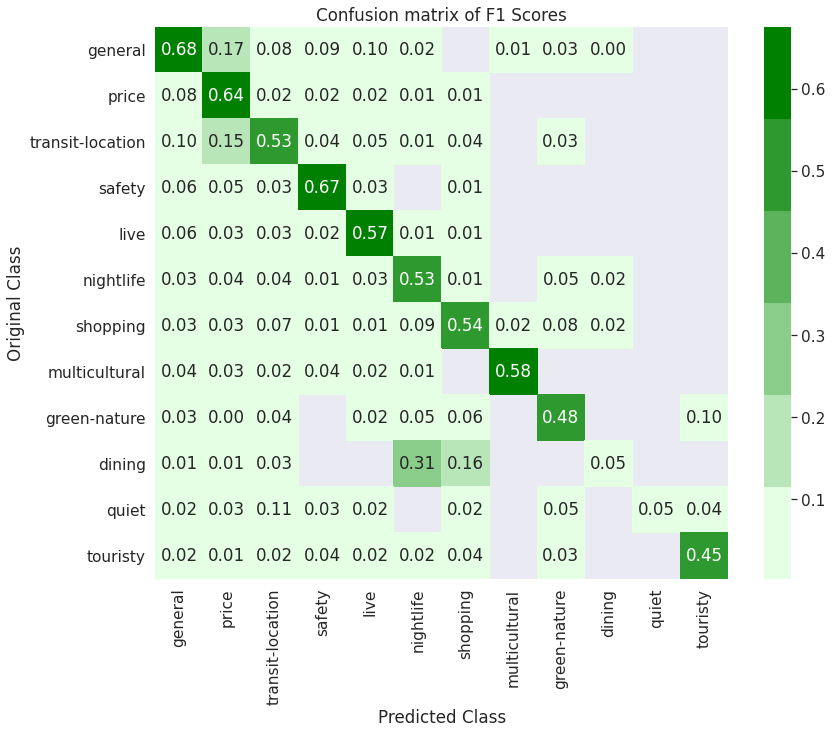

In [ ]:
preds_test, preds_val, preds_train, test_result_aspect, test_result_sentiment=essentials()
analyse_all()

### ShortComings of First Two Models:
1. Class Imbalance

## Here Onwards We address the class Imbalance using class weighting Methood

## Model 3

In [ ]:
train['aspect'].value_counts()

0     1180
1      500
2      428
3      352
4      221
5      158
6      143
7      123
8       95
9       93
10      54
11      49
Name: aspect, dtype: int64

## How have the class weight been assigned:
Class Weight for a class = Class with max entity / Individual Classes

Example: 
1. Weight with class 0 would be 1 as (1180/1180)=1
2. Weight with class 11 would 24.08 as (1180/49)=24.28


In [ ]:
weights_aspect={0:1, 1:2.42, 2:2.83, 3:3.4, 4:5.66, 5:8.5, 6:9.44, 7:9.4,8:12.18, 9:12.45, 10:22.66, 11:24.08 }
weights_polarity={ 0:2.68, 1:1}

In [ ]:
tf.keras.backend.clear_session()
embedded_layer = Embedding(2733,300,weights=[embedded],input_length=180,trainable=False)

input_text = Input(shape=(180,),name="input_text")
x_1 = embedded_layer(input_text)
# x_1 = LSTM(128, return_sequences=True)(x_1)
x_1=Bidirectional(LSTM(128, return_sequences=True))(x_1)
flat_text = Flatten()(x_1)

input_location = Input(shape=(1,),name= "location")
layer_location = Embedding(2,1,trainable=False)(input_location)
flat_location = Flatten()(layer_location)

model = concatenate([flat_text ,flat_location])
# https://stackoverflow.com/questions/55181044/keras-custom-layer-valueerror-an-operation-has-none-for-gradient
model = Dense(32,activation="relu",kernel_initializer="he_uniform")(model)
model = Dropout(0.5)(model)

outputs_aspect = Dense(12, activation='softmax', name="out_aspect")(model)   
outputs_sentiment = Dense(2, activation='softmax', name="out_sentiment")(model)

model = Model(inputs = [input_text , input_location  ],outputs=[outputs_aspect, outputs_sentiment])

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy', tf.keras.metrics.AUC()])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text (InputLayer)         (None, 180)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 180, 300)     819900      input_text[0][0]                 
__________________________________________________________________________________________________
location (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 180, 256)     439296      embedding_1[0][0]                
____________________________________________________________________________________________

In [ ]:
checkpoint_filepath = '/tmp/checkpoint_5'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', save_best_only=True)

es=EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history=model.fit(train_req_x,{"out_aspect":y_train_aspect, "out_sentiment":y_train_sentiment}, 
                  validation_data=(val_req_x,{"out_aspect":y_val_aspect, "out_sentiment":y_val_sentiment}),
                  batch_size=128,epochs=40,verbose=1, callbacks=[model_checkpoint_callback, es], class_weight={"out_aspect":weights_aspect, "out_sentiment":weights_polarity})


Train on 3396 samples, validate on 838 samples
Epoch 1/40
3396/3396 [==============================] - 24s 7ms/step - loss: 11.6833 - out_aspect_loss: 10.6435 - out_sentiment_loss: 1.0017 - out_aspect_accuracy: 0.1193 - out_aspect_auc: 0.7008 - out_sentiment_accuracy: 0.5062 - out_sentiment_auc: 0.7063 - val_loss: 3.0428 - val_out_aspect_loss: 2.3346 - val_out_sentiment_loss: 0.7048 - val_out_aspect_accuracy: 0.1897 - val_out_aspect_auc: 0.7393 - val_out_sentiment_accuracy: 0.4785 - val_out_sentiment_auc: 0.7406
Epoch 2/40
3396/3396 [==============================] - 23s 7ms/step - loss: 10.3766 - out_aspect_loss: 9.3963 - out_sentiment_loss: 0.9712 - out_aspect_accuracy: 0.2064 - out_aspect_auc: 0.7579 - out_sentiment_accuracy: 0.5813 - out_sentiment_auc: 0.7588 - val_loss: 2.7262 - val_out_aspect_loss: 2.1555 - val_out_sentiment_loss: 0.5663 - val_out_aspect_accuracy: 0.2900 - val_out_aspect_auc: 0.7742 - val_out_sentiment_accuracy: 0.7303 - val_out_sentiment_auc: 0.7745
Epoch 3/40
3

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
-------------------- Sentiment --------------------
train Sentiment F1 :  0.7912249705535924
val Sentiment F1 :  0.7494033412887827
Test Sentiment F1 :  0.7036374478234944
-------------------- Aspect --------------------
train Aspect F1 :  0.6633263294003555
val Aspect F1 :  0.5919343814080655
Test Aspect F1 :  0.5864763846415223
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


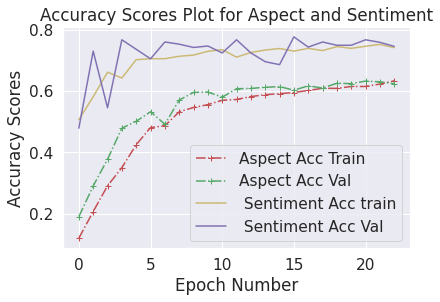

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


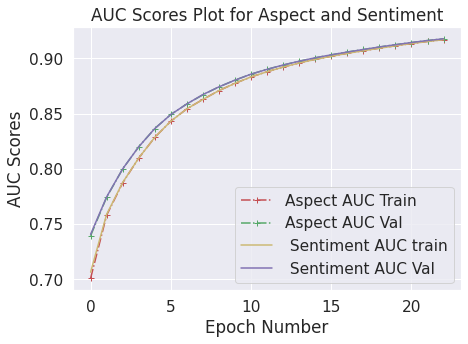

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


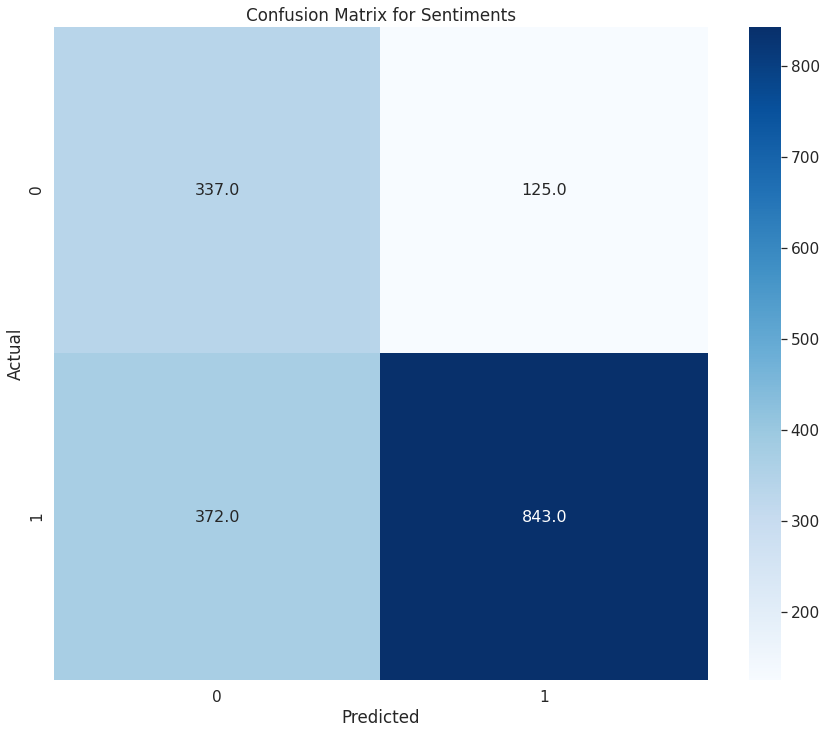

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


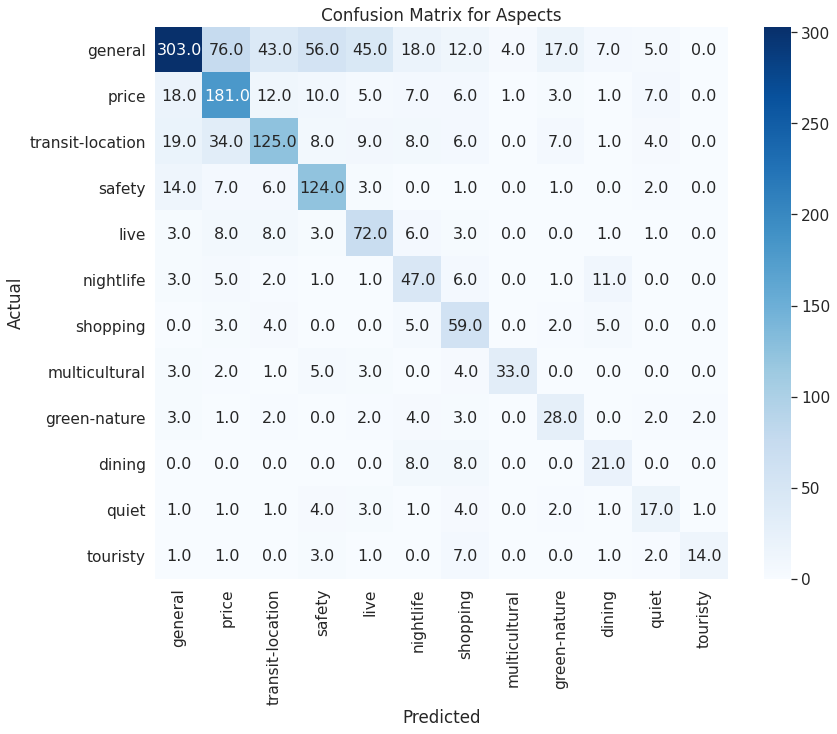

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide


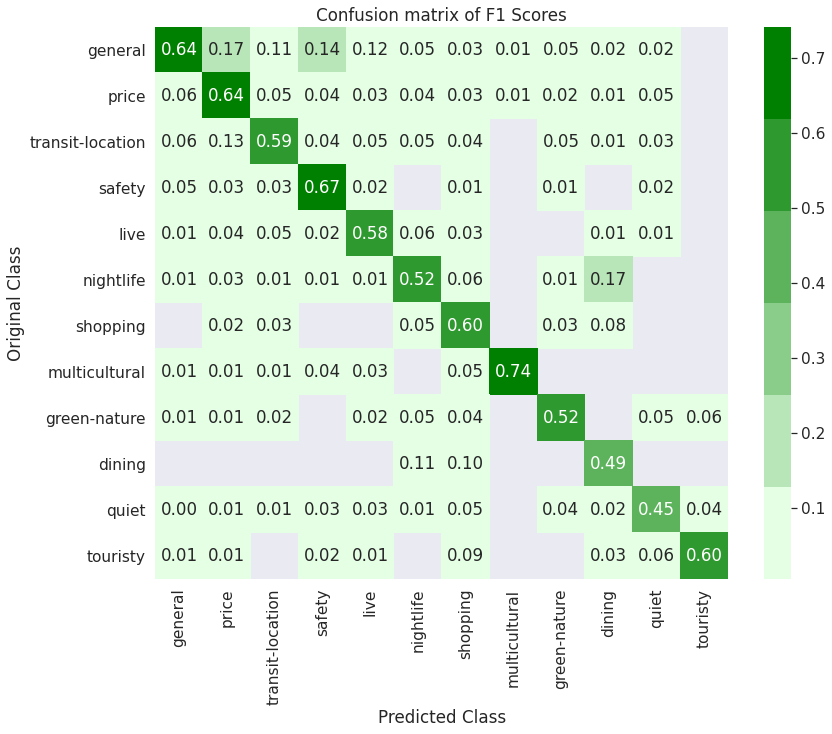

In [ ]:
preds_test, preds_val, preds_train, test_result_aspect, test_result_sentiment=essentials()
analyse_all()

Observation: Class Weighing seems to handle performance for classes Green-Nature, dining, quiet and touristy

## Model 4

In [ ]:

tf.keras.backend.clear_session()
embedded_layer = Embedding(2733,300,weights=[embedded],input_length=180,trainable=False)

input_text = Input(shape=(180,),name="input_text")
x_1 = embedded_layer(input_text)
# x_1 = LSTM(128, return_sequences=True)(x_1)
x_1=Bidirectional(LSTM(256, return_sequences=True))(x_1)
flat_text = Flatten()(x_1)

input_location = Input(shape=(1,),name= "location")
layer_location = Embedding(2,1,trainable=False)(input_location)
flat_location = Flatten()(layer_location)

model = concatenate([flat_text ,flat_location])
# https://stackoverflow.com/questions/55181044/keras-custom-layer-valueerror-an-operation-has-none-for-gradient
model = Dense(32,activation="relu",kernel_initializer="he_uniform")(model)
model = Dropout(0.5)(model)

outputs_aspect = Dense(12, activation='softmax', name="out_aspect")(model)   
outputs_sentiment = Dense(2, activation='softmax', name="out_sentiment")(model)

model = Model(inputs = [input_text , input_location  ],outputs=[outputs_aspect, outputs_sentiment])

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy', tf.keras.metrics.AUC()])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text (InputLayer)         (None, 180)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 180, 300)     819900      input_text[0][0]                 
__________________________________________________________________________________________________
location (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 180, 512)     1140736     embedding_1[0][0]                
____________________________________________________________________________________________

In [ ]:
checkpoint_filepath = '/tmp/checkpoint_6'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', save_best_only=True)

es=EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history=model.fit(train_req_x,{"out_aspect":y_train_aspect, "out_sentiment":y_train_sentiment}, 
                  validation_data=(val_req_x,{"out_aspect":y_val_aspect, "out_sentiment":y_val_sentiment}),
                  batch_size=128,epochs=40,verbose=1, callbacks=[model_checkpoint_callback, es], class_weight={"out_aspect":weights_aspect, "out_sentiment":weights_polarity})


Train on 3396 samples, validate on 838 samples
Epoch 1/40
3396/3396 [==============================] - 25s 7ms/step - loss: 11.7262 - out_aspect_loss: 10.6629 - out_sentiment_loss: 1.0284 - out_aspect_accuracy: 0.1516 - out_aspect_auc: 0.6953 - out_sentiment_accuracy: 0.5356 - out_sentiment_auc: 0.7094 - val_loss: 2.9786 - val_out_aspect_loss: 2.3110 - val_out_sentiment_loss: 0.6658 - val_out_aspect_accuracy: 0.2649 - val_out_aspect_auc: 0.7442 - val_out_sentiment_accuracy: 0.6026 - val_out_sentiment_auc: 0.7467
Epoch 2/40
3396/3396 [==============================] - 24s 7ms/step - loss: 10.6644 - out_aspect_loss: 9.7134 - out_sentiment_loss: 0.9458 - out_aspect_accuracy: 0.2512 - out_aspect_auc: 0.7682 - out_sentiment_accuracy: 0.5872 - out_sentiment_auc: 0.7691 - val_loss: 2.7562 - val_out_aspect_loss: 2.1126 - val_out_sentiment_loss: 0.6448 - val_out_aspect_accuracy: 0.2924 - val_out_aspect_auc: 0.7839 - val_out_sentiment_accuracy: 0.6086 - val_out_sentiment_auc: 0.7852
Epoch 3/40
3

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
-------------------- Sentiment --------------------
train Sentiment F1 :  0.8224381625441696
val Sentiment F1 :  0.7756563245823389
Test Sentiment F1 :  0.7638640429338104
-------------------- Aspect --------------------
train Aspect F1 :  0.6812339331619538
val Aspect F1 :  0.6009582477754962
Test Aspect F1 :  0.5985054347826086
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


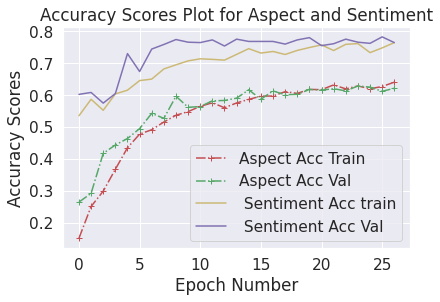

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


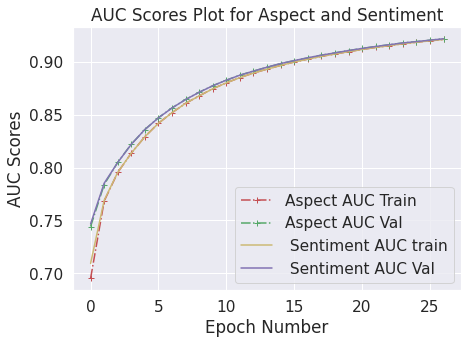

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


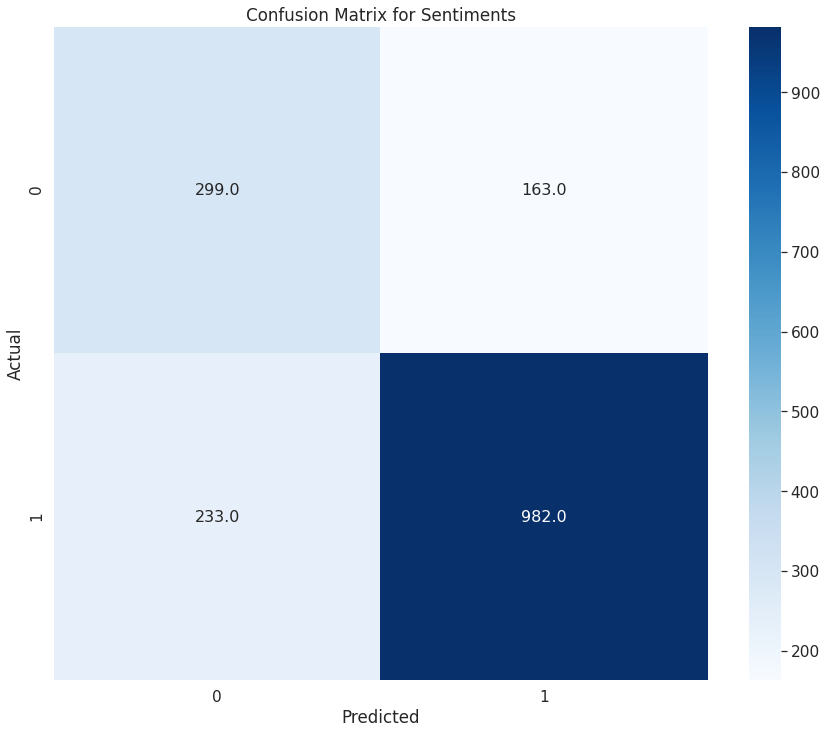

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


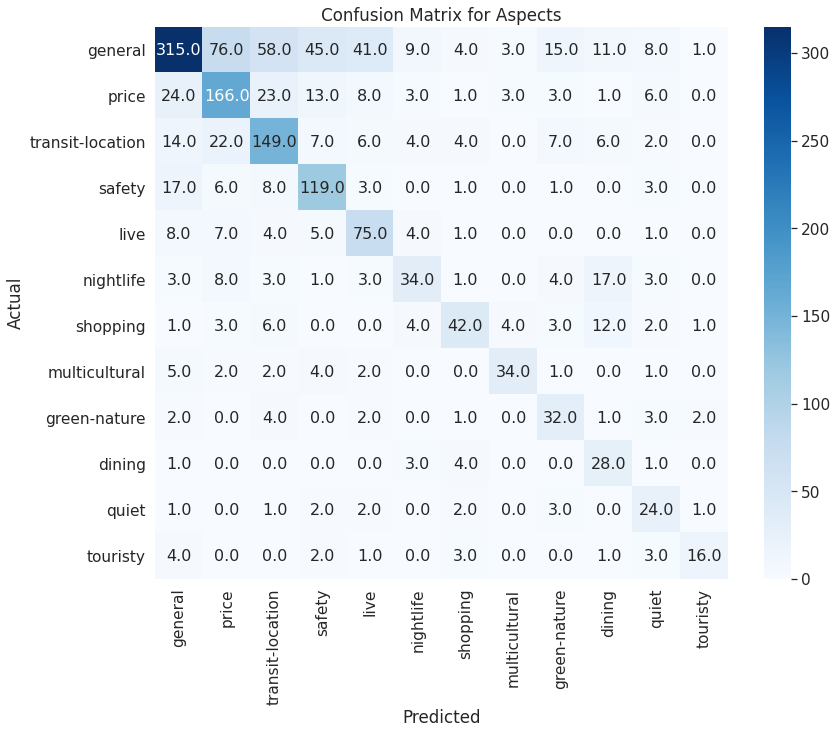

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide


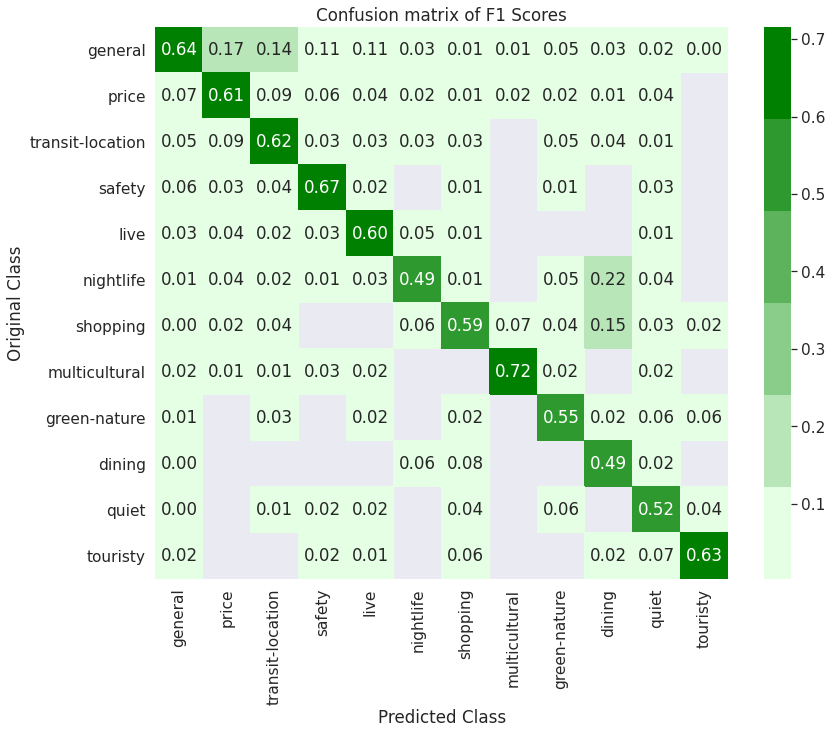

In [ ]:
preds_test, preds_val, preds_train, test_result_aspect, test_result_sentiment=essentials()
analyse_all()

## Model 5

In [ ]:
tf.keras.backend.clear_session()
embedded_layer = Embedding(2733,300,weights=[embedded],input_length=180,trainable=False)

input_text = Input(shape=(180,),name="input_text")
x_1 = embedded_layer(input_text)
x_1 = LSTM(128, return_sequences=True)(x_1)
# x_1=Bidirectional(LSTM(128, return_sequences=True))(x_1)
flat_text = Flatten()(x_1)

input_location = Input(shape=(1,),name= "location")
layer_location = Embedding(2,1,trainable=False)(input_location)
flat_location = Flatten()(layer_location)


model = concatenate([flat_text ,flat_location])
# https://stackoverflow.com/questions/55181044/keras-custom-layer-valueerror-an-operation-has-none-for-gradient
model = Dense(32,activation="relu",kernel_initializer="he_uniform")(model)
# model = Dropout(0.5)(model)

outputs_aspect = Dense(12, activation='softmax', name="out_aspect")(model)   
outputs_sentiment = Dense(2, activation='softmax', name="out_sentiment")(model)

model = Model(inputs = [input_text , input_location  ],outputs=[outputs_aspect, outputs_sentiment])

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
checkpoint_filepath = '/tmp/checkpoint_5'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', save_best_only=True)

es=EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history=model.fit(train_req_x,{"out_aspect":y_train_aspect, "out_sentiment":y_train_sentiment}, 
                  validation_data=(val_req_x,{"out_aspect":y_val_aspect, "out_sentiment":y_val_sentiment}),
                  batch_size=128,epochs=40,verbose=1, callbacks=[model_checkpoint_callback, es], class_weight={"out_aspect":weights_aspect, "out_sentiment":weights_polarity})


Train on 3396 samples, validate on 838 samples
Epoch 1/40
3396/3396 [==============================] - 13s 4ms/step - loss: 11.3553 - out_aspect_loss: 10.3151 - out_sentiment_loss: 1.0030 - out_aspect_accuracy: 0.1755 - out_aspect_auc: 0.7775 - out_sentiment_accuracy: 0.5244 - out_sentiment_auc: 0.7687 - val_loss: 2.6305 - val_out_aspect_loss: 2.0280 - val_out_sentiment_loss: 0.5997 - val_out_aspect_accuracy: 0.3640 - val_out_aspect_auc: 0.8099 - val_out_sentiment_accuracy: 0.6945 - val_out_sentiment_auc: 0.8098
Epoch 2/40
3396/3396 [==============================] - 12s 4ms/step - loss: 8.9890 - out_aspect_loss: 8.0778 - out_sentiment_loss: 0.8935 - out_aspect_accuracy: 0.3569 - out_aspect_auc: 0.8317 - out_sentiment_accuracy: 0.6369 - out_sentiment_auc: 0.8319 - val_loss: 2.3046 - val_out_aspect_loss: 1.8111 - val_out_sentiment_loss: 0.4960 - val_out_aspect_accuracy: 0.4057 - val_out_aspect_auc: 0.8441 - val_out_sentiment_accuracy: 0.7470 - val_out_sentiment_auc: 0.8440
Epoch 3/40
33

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
-------------------- Sentiment --------------------
train Sentiment F1 :  0.8639575971731449
val Sentiment F1 :  0.7971360381861575
Test Sentiment F1 :  0.7692307692307693
-------------------- Aspect --------------------
train Aspect F1 :  0.698034360006191
val Aspect F1 :  0.6219354838709678
Test Aspect F1 :  0.6102246825138391
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


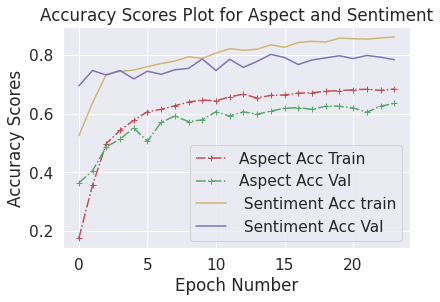

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


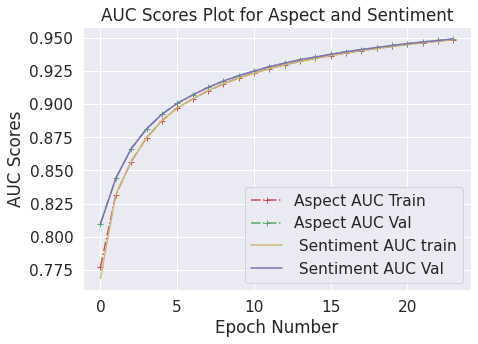

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


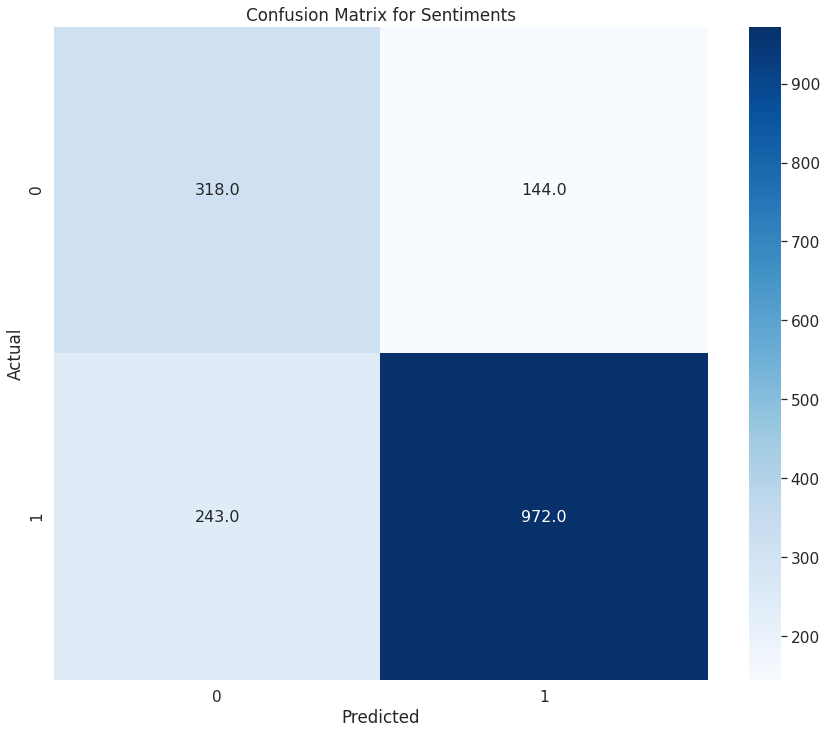

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


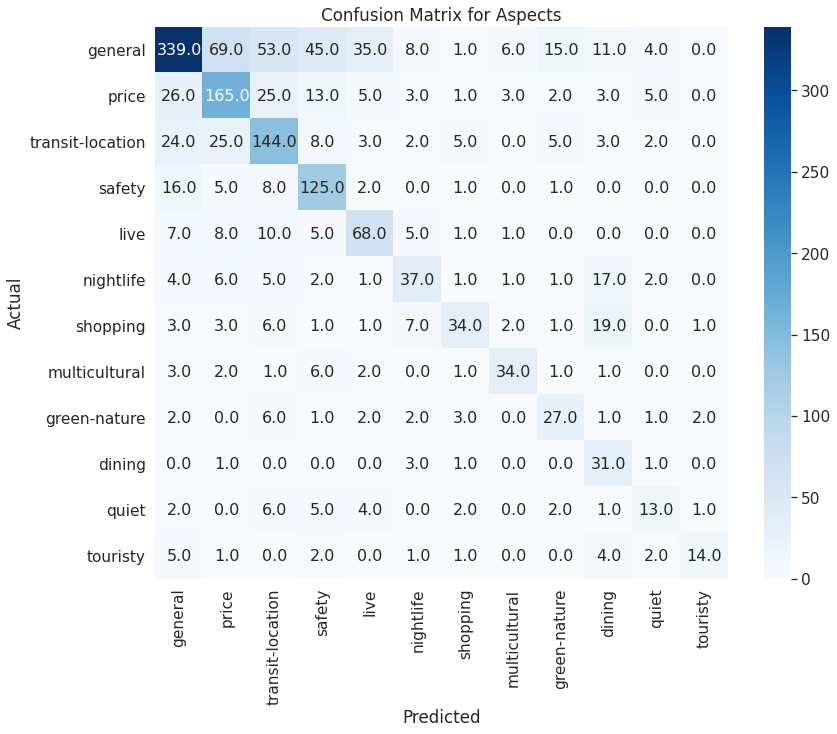

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide


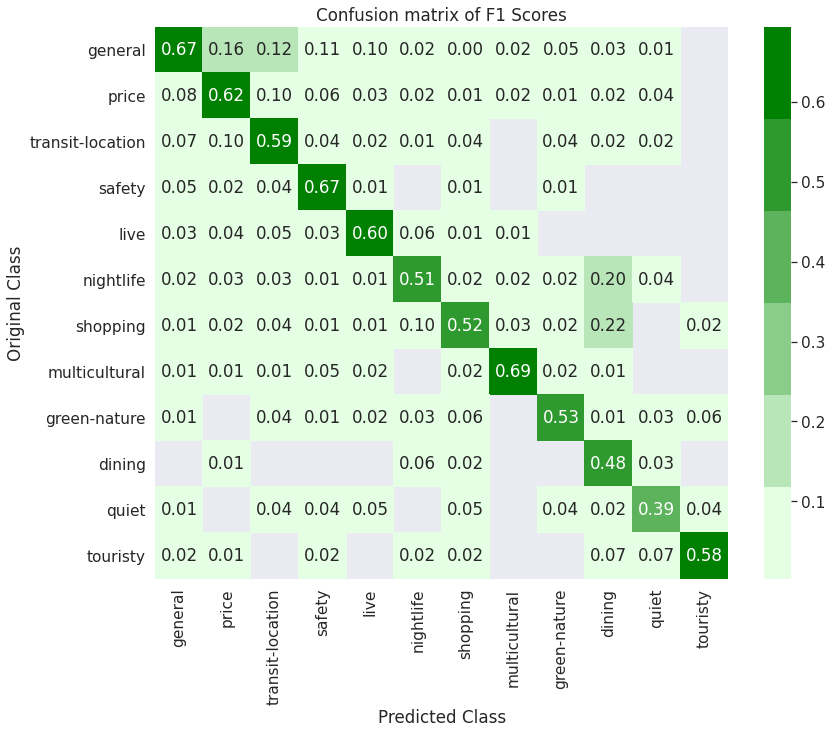

In [ ]:
preds_test, preds_val, preds_train, test_result_aspect, test_result_sentiment=essentials()
analyse_all()

## Model 6

In [ ]:
tf.keras.backend.clear_session()
embedded_layer = Embedding(2733,300,weights=[embedded],input_length=180,trainable=False)

input_text = Input(shape=(180,),name="input_text")
x_1 = embedded_layer(input_text)
x_1 = LSTM(256, return_sequences=True)(x_1)
# x_1=Bidirectional(LSTM(128, return_sequences=True))(x_1)
flat_text = Flatten()(x_1)


input_location = Input(shape=(1,),name= "location")
layer_location = Embedding(2,1,trainable=False)(input_location)
flat_location = Flatten()(layer_location)


model = concatenate([flat_text ,flat_location])
# https://stackoverflow.com/questions/55181044/keras-custom-layer-valueerror-an-operation-has-none-for-gradient
model = Dense(32,activation="relu",kernel_initializer="he_uniform")(model)
# model = Dropout(0.5)(model)

outputs_aspect = Dense(12, activation='softmax', name="out_aspect")(model)   
outputs_sentiment = Dense(2, activation='softmax', name="out_sentiment")(model)

model = Model(inputs = [input_text , input_location  ],outputs=[outputs_aspect, outputs_sentiment])

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
checkpoint_filepath = '/tmp/checkpoint_5'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', save_best_only=True)

es=EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history=model.fit(train_req_x,{"out_aspect":y_train_aspect, "out_sentiment":y_train_sentiment}, 
                  validation_data=(val_req_x,{"out_aspect":y_val_aspect, "out_sentiment":y_val_sentiment}),
                  batch_size=128,epochs=40,verbose=1, callbacks=[model_checkpoint_callback, es], class_weight={"out_aspect":weights_aspect, "out_sentiment":weights_polarity})


Train on 3396 samples, validate on 838 samples
Epoch 1/40
3396/3396 [==============================] - 13s 4ms/step - loss: 11.0380 - out_aspect_loss: 10.0312 - out_sentiment_loss: 1.0002 - out_aspect_accuracy: 0.1861 - out_aspect_auc: 0.7238 - out_sentiment_accuracy: 0.5395 - out_sentiment_auc: 0.7384 - val_loss: 2.9258 - val_out_aspect_loss: 2.1223 - val_out_sentiment_loss: 0.8031 - val_out_aspect_accuracy: 0.3365 - val_out_aspect_auc: 0.7899 - val_out_sentiment_accuracy: 0.4833 - val_out_sentiment_auc: 0.7907
Epoch 2/40
3396/3396 [==============================] - 12s 4ms/step - loss: 8.3980 - out_aspect_loss: 7.5515 - out_sentiment_loss: 0.8596 - out_aspect_accuracy: 0.4311 - out_aspect_auc: 0.8168 - out_sentiment_accuracy: 0.6667 - out_sentiment_auc: 0.8168 - val_loss: 2.3593 - val_out_aspect_loss: 1.8113 - val_out_sentiment_loss: 0.5579 - val_out_aspect_accuracy: 0.4224 - val_out_aspect_auc: 0.8381 - val_out_sentiment_accuracy: 0.7267 - val_out_sentiment_auc: 0.8382
Epoch 3/40
33

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
-------------------- Sentiment --------------------
train Sentiment F1 :  0.8418727915194346
val Sentiment F1 :  0.7935560859188545
Test Sentiment F1 :  0.7650566487775791
-------------------- Aspect --------------------
train Aspect F1 :  0.6607258587167856
val Aspect F1 :  0.5852981969486823
Test Aspect F1 :  0.5722164770768701
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


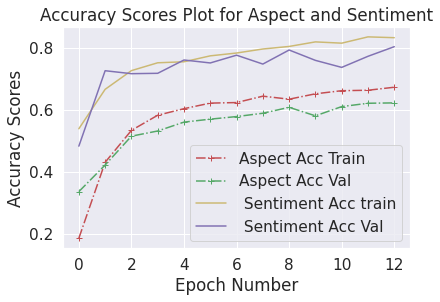

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


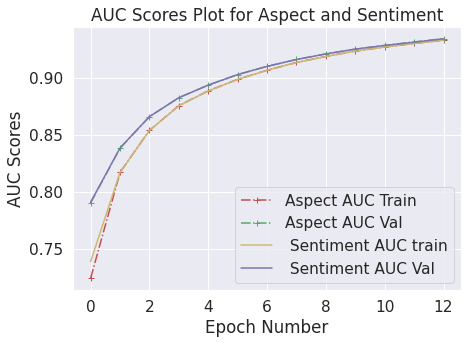

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


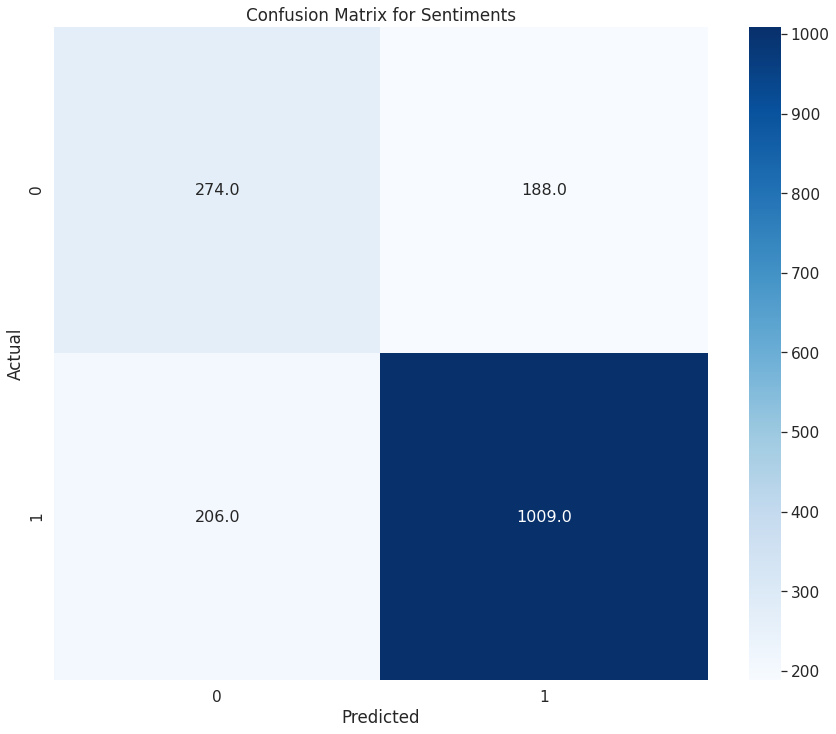

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


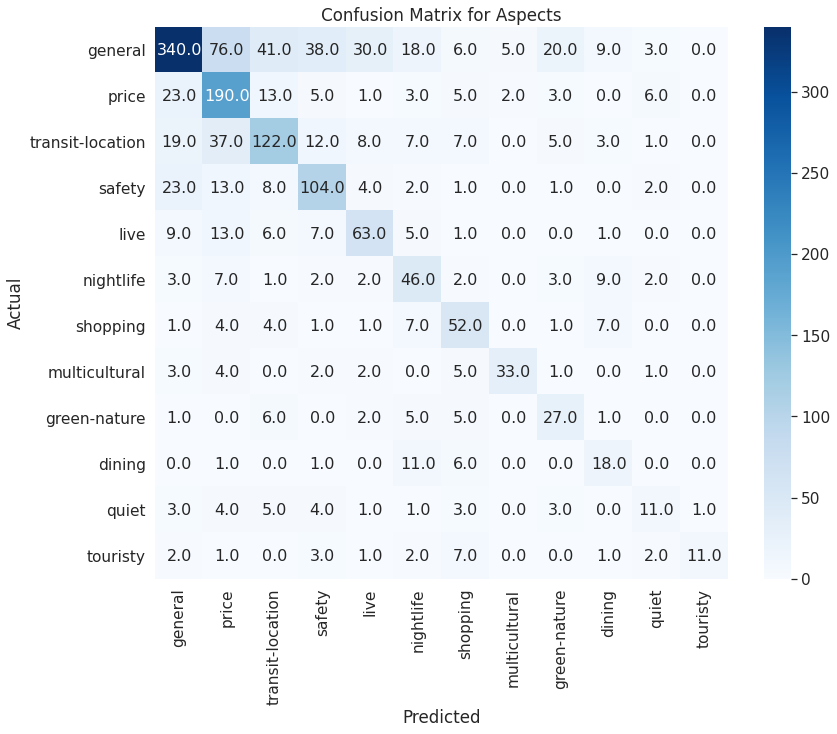

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide


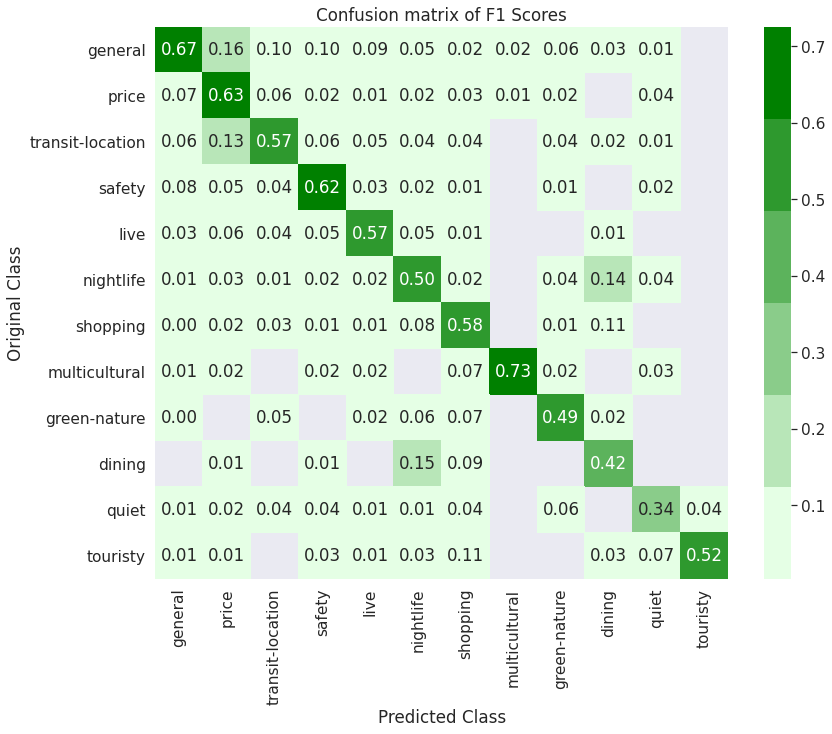

In [ ]:
preds_test, preds_val, preds_train, test_result_aspect, test_result_sentiment=essentials()
analyse_all()

## Model 7

# Attention

Source:  https://www.analyticsvidhya.com/blog/2019/11/comprehensive-guide-attention-mechanism-deep-learning/

In [ ]:
import keras.backend as K
from keras.layers import Layer

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [ ]:

# tf.keras.backend.clear_session()
embedded_layer = Embedding(2733,300,weights=[embedded],input_length=180,trainable=False)

input_text = Input(shape=(180,),name="input_text")
x_1 = embedded_layer(input_text)
x_1 = LSTM(128, return_sequences=True)(x_1)
flat_text=attention()(x_1)


input_location = Input(shape=(1,),name= "location")
layer_location = Embedding(2,1,trainable=False)(input_location)
flat_location = Flatten()(layer_location)


model = concatenate([flat_text ,flat_location])
# https://stackoverflow.com/questions/55181044/keras-custom-layer-valueerror-an-operation-has-none-for-gradient
model = Dense(32,activation="relu",kernel_initializer="he_uniform")(model)
# model = Dropout(0.5)(model)

outputs_aspect = Dense(12, activation='softmax', name="out_aspect")(model)   
outputs_sentiment = Dense(2, activation='softmax', name="out_sentiment")(model)

model = Model(inputs = [input_text , input_location  ],outputs=[outputs_aspect, outputs_sentiment])

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy', tf.keras.metrics.AUC()])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text (InputLayer)         [(None, 180)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 180, 300)     819900      input_text[0][0]                 
__________________________________________________________________________________________________
location (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 180, 128)     219648      embedding[0][0]                  
_______________________________________________________________________________________

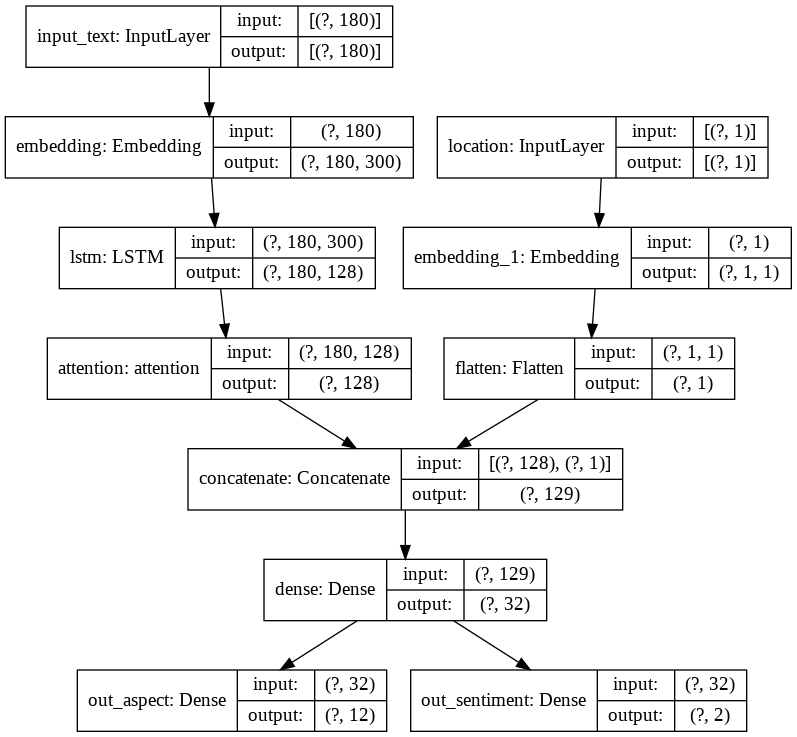

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model_1.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
checkpoint_filepath = '/tmp/checkpoint_7'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', save_best_only=True)

es=EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history=model.fit(train_req_x,{"out_aspect":y_train_aspect, "out_sentiment":y_train_sentiment}, 
                  validation_data=(val_req_x,{"out_aspect":y_val_aspect, "out_sentiment":y_val_sentiment}),
                  batch_size=128,epochs=40,verbose=1, callbacks=[model_checkpoint_callback, es], class_weight={"out_aspect":weights_aspect, "out_sentiment":weights_polarity})


Train on 3396 samples, validate on 838 samples
Epoch 1/40
3396/3396 [==============================] - 13s 4ms/step - loss: 11.6510 - out_aspect_loss: 10.6396 - out_sentiment_loss: 1.0052 - out_aspect_accuracy: 0.1031 - out_aspect_auc: 0.6996 - out_sentiment_accuracy: 0.5707 - out_sentiment_auc: 0.7071 - val_loss: 3.1562 - val_out_aspect_loss: 2.4526 - val_out_sentiment_loss: 0.7034 - val_out_aspect_accuracy: 0.1420 - val_out_aspect_auc: 0.7106 - val_out_sentiment_accuracy: 0.4320 - val_out_sentiment_auc: 0.7121
Epoch 2/40
3396/3396 [==============================] - 12s 4ms/step - loss: 10.9642 - out_aspect_loss: 9.9932 - out_sentiment_loss: 0.9632 - out_aspect_accuracy: 0.1643 - out_aspect_auc: 0.7226 - out_sentiment_accuracy: 0.5492 - out_sentiment_auc: 0.7240 - val_loss: 2.9378 - val_out_aspect_loss: 2.3700 - val_out_sentiment_loss: 0.5652 - val_out_aspect_accuracy: 0.1575 - val_out_aspect_auc: 0.7347 - val_out_sentiment_accuracy: 0.7387 - val_out_sentiment_auc: 0.7357
Epoch 3/40
3

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
-------------------- Sentiment --------------------
train Sentiment F1 :  0.8445229681978799
val Sentiment F1 :  0.7899761336515513
Test Sentiment F1 :  0.7817531305903399
-------------------- Aspect --------------------
train Aspect F1 :  0.6825346784363178
val Aspect F1 :  0.6289707750952986
Test Aspect F1 :  0.6098039215686275
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


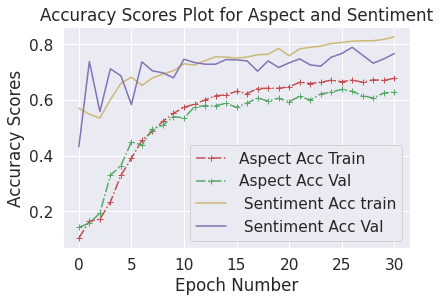

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


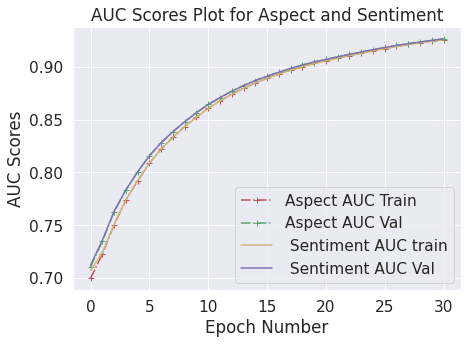

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


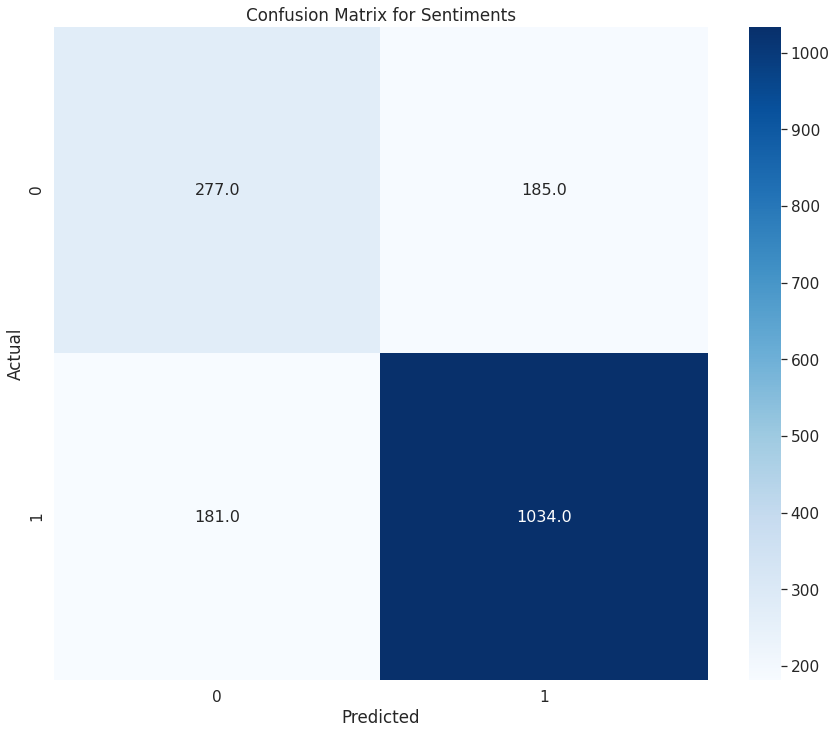

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


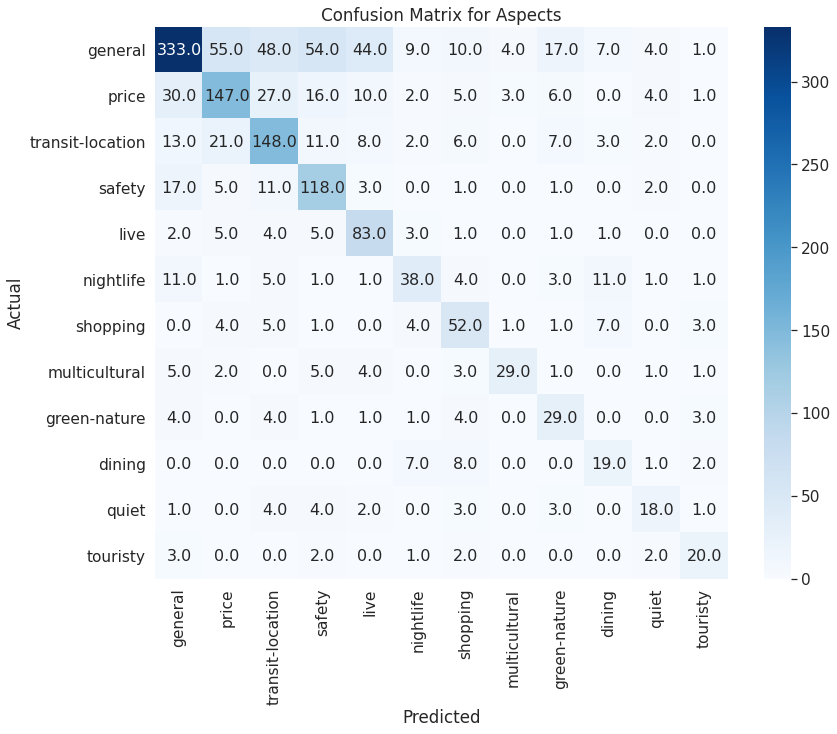

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide


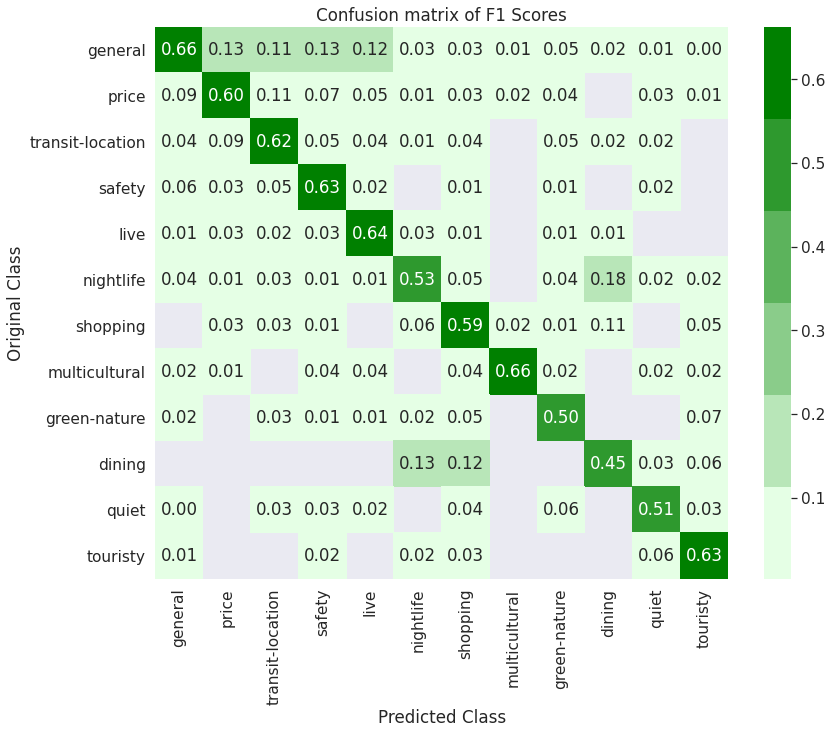

In [ ]:
preds_test, preds_val, preds_train, test_result_aspect, test_result_sentiment=essentials()
analyse_all()

## Observation: This Model Seems to address the F1 Score of all the classes very Uniformly.

### Using this Model for Final Submission

In [ ]:
#FINAL DATAFRAME CONSOLIDATION BEGINS#

SentPred = np.argmax(test_result_sentiment, axis=1)   ## Taking the class with maximum score- Sentiment Prediction
AsptPred = np.argmax(test_result_aspect, axis=1)      ## Taking the class with maximum score- Aspect Prediction
aspect2idx={"general":0, "price":1,"transit-location":2,"safety":3,"live":4,"nightlife":5,
            "shopping":6,"multicultural":7,"green-nature":8,"dining":9,"quiet":10,"touristy":11}
key_list = list(aspect2idx.keys())
val_list = list(aspect2idx.values())

## Putting Predictions into DataFrame to convert into final Predictions

test['sentiment_predicted'] = SentPred   
test['aspect_predicted'] = AsptPred
test['sentiment_predicted'] = test['sentiment_predicted'].apply(lambda x: 'postive' if x == 1 else 'negative')
test['aspect_predicted'] = test['aspect_predicted'].apply(lambda x: key_list[val_list.index(x)])
test['polarity'] = test['polarity'].apply(lambda x: 'postive' if x == 1 else 'negative')
test['aspect'] = test['aspect'].apply(lambda x: key_list[val_list.index(x)])

## Renaming Columns as asked in Task

test = test.rename(columns = {'polarity':'sentiment','location':'target_entity'})
test_org = test[['id','text','target_entity','aspect','sentiment']]
test_pred = test[['id','text','target_entity','sentiment_predicted','aspect_predicted']]
test_pred = test_pred.rename(columns = {'sentiment_predicted':'sentiment','aspect_predicted':'aspect'})
test_pred["model_pred"] = None

## Making Predictions


d = {}
for i in test_pred.index:
    d["sentiment"] = test_pred['sentiment'][i]
    d["aspect"] = test_pred['aspect'][i]
    d["target_entity"] = test_pred['target_entity'][i]
    test_pred["model_pred"][i] = d
    d = {}
test_pred.drop(["target_entity","sentiment","aspect"],axis = 1,inplace = True)

## Predictions to a new DataFrame


check = test_pred.groupby(["id","text"]).apply(lambda x: list(x["model_pred"]))
check_2 = pd.DataFrame(check).reset_index()
check_2 = check_2.rename(columns={0:"model_pred"})
test_org["opinions"] = None
d = {}
for i in test_org.index:
    d["sentiment"] = test_org['sentiment'][i]
    d["aspect"] = test_org['aspect'][i]
    d["target_entity"] = test_org['target_entity'][i]
    test_org["opinions"][i] = d
    d = {}
test_org.drop(["target_entity","sentiment","aspect"],axis = 1,inplace = True)
check = test_org.groupby(["id","text"]).apply(lambda x: list(x["opinions"]))
check_3 = pd.DataFrame(check).reset_index()
check_3 = check_3.rename(columns={0:"opinions"})

## Making The Final Dataframe


final_dataFrame = pd.merge(check_2,check_3,on = ["id","text"],how = 'inner')
final_dataFrame = final_dataFrame[["opinions","id","text","model_pred"]]


### Converting File to .jsonl format
### Sources:
1. https://medium.com/@galea/how-to-love-jsonl-using-json-line-format-in-your-workflow-b6884f65175b

2. https://stackoverflow.com/questions/50916422/python-typeerror-object-of-type-int64-is-not-json-serializable/50916741

In [ ]:
insert_docs = []
document = dict()
for i in final_dataFrame.index:
    document["opinions"] = final_dataFrame["opinions"][i]
    document["id"] = final_dataFrame["id"][i]
    document["text"] = final_dataFrame["text"][i]
    document["model_pred"] = final_dataFrame["model_pred"][i]
    #document = dict(document)
    insert_docs.append(document)
    document = dict()

def myconverter(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, datetime.datetime):
            return obj.__str__()

def dump_jsonl(data, output_path, append=False):
    """
    Write list of objects to a JSON lines file.
    """
    mode = 'a+' if append else 'w'
    with open(output_path, mode, encoding='utf-8') as f:
        for line in data:
            json_record = json.dumps(line,ensure_ascii=False,default=myconverter) #indent=2
            f.write(json_record + '\n')
    # print('Wrote {} records to {}'.format(len(data), output_path))

def load_jsonl(input_path) -> list:
    """
    Read list of objects from a JSON lines file.
    """
    data = []
    for line in open(input_path, "r", encoding="utf-8"):
        data.append(json.loads(line))
    # print('Loaded {} records from {}'.format(len(data), input_path))
    return data

### Dumping DataFrame to .jsonl format

In [ ]:
dump_jsonl(insert_docs,'final_output.jsonl',append=True)
# Explain difference in format on colab and jupyter Notebook #
file_data = load_jsonl('/content/final_output_lol.jsonl')
file_data_pandas = pd.read_json('final_output.jsonl',lines = True,encoding="utf8")
#FINAL DATAFRAME CONSOLIDATION ENDS#

## Model 8

In [ ]:
tf.keras.backend.clear_session()
embedded_layer = Embedding(2733,300,weights=[embedded],input_length=180,trainable=False)

input_text = Input(shape=(180,),name="input_text")
x_1 = embedded_layer(input_text)
# x_1 = LSTM(128, return_sequences=True)(x_1)
x_1=Bidirectional(LSTM(128, return_sequences=True))(x_1)
flat_text=attention()(x_1)

input_location = Input(shape=(1,),name= "location")
layer_location = Embedding(2,1,trainable=False)(input_location)
flat_location = Flatten()(layer_location)


model = concatenate([flat_text ,flat_location])
# https://stackoverflow.com/questions/55181044/keras-custom-layer-valueerror-an-operation-has-none-for-gradient
model = Dense(32,activation="relu",kernel_initializer="he_uniform")(model)
# model = Dropout(0.5)(model)

outputs_aspect = Dense(12, activation='softmax', name="out_aspect")(model)   
outputs_sentiment = Dense(2, activation='softmax', name="out_sentiment")(model)

model = Model(inputs = [input_text , input_location  ],outputs=[outputs_aspect, outputs_sentiment])

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy', tf.keras.metrics.AUC()])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text (InputLayer)         (None, 180)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 180, 300)     819900      input_text[0][0]                 
__________________________________________________________________________________________________
location (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 180, 256)     439296      embedding_1[0][0]                
____________________________________________________________________________________________

In [ ]:
checkpoint_filepath = '/tmp/checkpoint_8'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', save_best_only=True)

es=EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history=model.fit(train_req_x,{"out_aspect":y_train_aspect, "out_sentiment":y_train_sentiment}, 
                  validation_data=(val_req_x,{"out_aspect":y_val_aspect, "out_sentiment":y_val_sentiment}),
                  batch_size=128,epochs=40,verbose=1, callbacks=[model_checkpoint_callback, es], class_weight={"out_aspect":weights_aspect, "out_sentiment":weights_polarity})


Train on 3396 samples, validate on 838 samples
Epoch 1/40
3396/3396 [==============================] - 25s 7ms/step - loss: 11.5649 - out_aspect_loss: 10.5427 - out_sentiment_loss: 0.9982 - out_aspect_accuracy: 0.0674 - out_aspect_auc: 0.6830 - out_sentiment_accuracy: 0.3168 - out_sentiment_auc: 0.6988 - val_loss: 3.1726 - val_out_aspect_loss: 2.4329 - val_out_sentiment_loss: 0.7396 - val_out_aspect_accuracy: 0.1766 - val_out_aspect_auc: 0.7217 - val_out_sentiment_accuracy: 0.5084 - val_out_sentiment_auc: 0.7221
Epoch 2/40
3396/3396 [==============================] - 24s 7ms/step - loss: 10.5613 - out_aspect_loss: 9.6209 - out_sentiment_loss: 0.9496 - out_aspect_accuracy: 0.2473 - out_aspect_auc: 0.7571 - out_sentiment_accuracy: 0.4856 - out_sentiment_auc: 0.7577 - val_loss: 2.7755 - val_out_aspect_loss: 2.0812 - val_out_sentiment_loss: 0.6971 - val_out_aspect_accuracy: 0.3425 - val_out_aspect_auc: 0.7841 - val_out_sentiment_accuracy: 0.5095 - val_out_sentiment_auc: 0.7838
Epoch 3/40
3

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
-------------------- Sentiment --------------------
train Sentiment F1 :  0.8318610129564195
val Sentiment F1 :  0.7756563245823389
Test Sentiment F1 :  0.7698270721526534
-------------------- Aspect --------------------
train Aspect F1 :  0.6733858267716536
val Aspect F1 :  0.5880794701986755
Test Aspect F1 :  0.5795971410006499
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


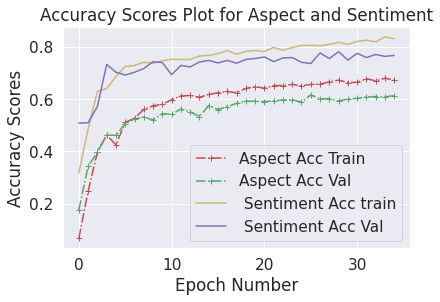

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


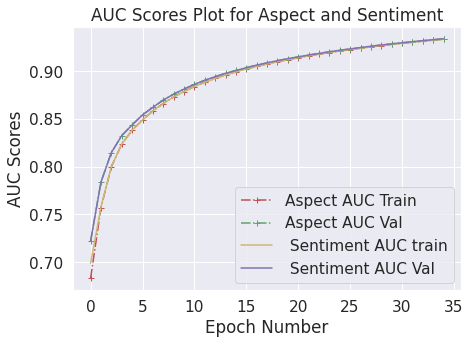

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


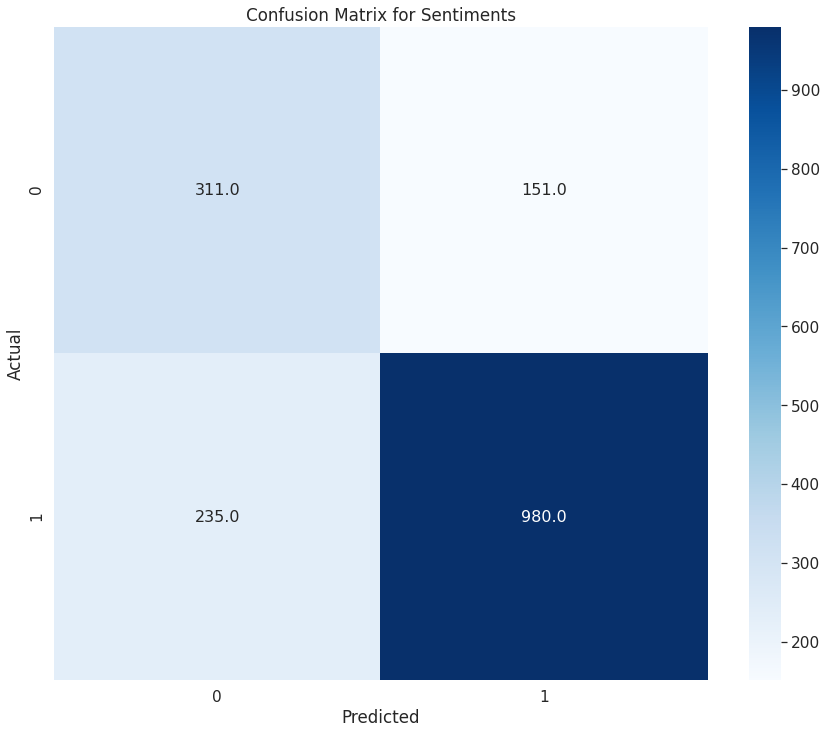

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


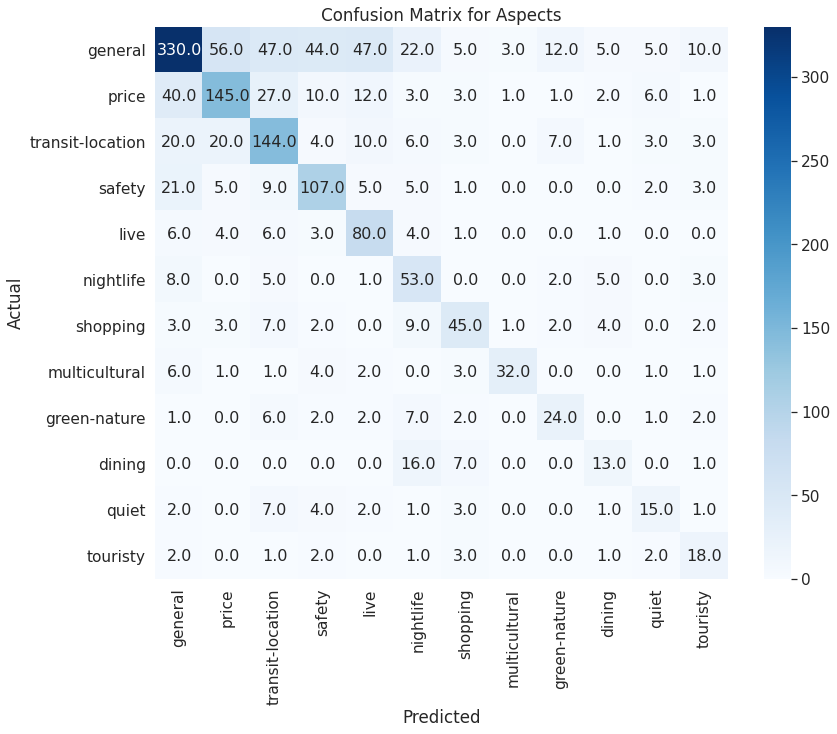

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide


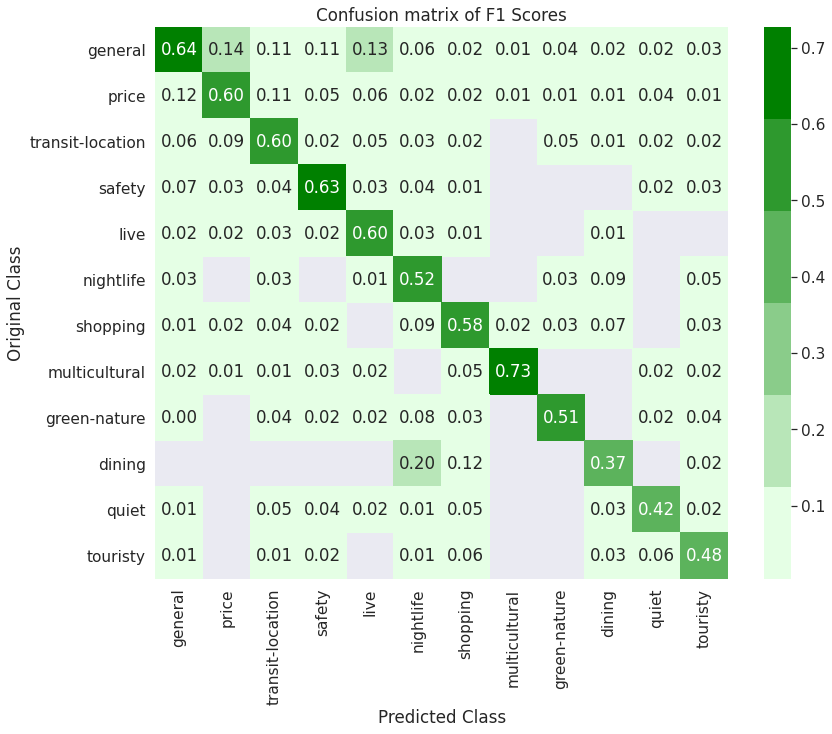

In [ ]:
preds_test, preds_val, preds_train, test_result_aspect, test_result_sentiment=essentials()
analyse_all()

## Model 9

In [ ]:
tf.keras.backend.clear_session()
embedded_layer = Embedding(2733,300,weights=[embedded],input_length=180,trainable=False)

input_text = Input(shape=(180,),name="input_text")
x_1 = embedded_layer(input_text)
# x_1 = LSTM(128, return_sequences=True)(x_1)
x_1=Bidirectional(LSTM(50, return_sequences=True))(x_1)
flat_text=attention()(x_1)

# flat_text = Flatten()(x_1)


input_location = Input(shape=(1,),name= "location")
layer_location = Embedding(2,1,trainable=False)(input_location)
flat_location = Flatten()(layer_location)


model = concatenate([flat_text ,flat_location])
# https://stackoverflow.com/questions/55181044/keras-custom-layer-valueerror-an-operation-has-none-for-gradient
# model = Dense(32,activation="relu",kernel_initializer="he_uniform")(model)
model = Dropout(0.001)(model)

outputs_aspect = Dense(12, activation='softmax', name="out_aspect")(model)   
outputs_sentiment = Dense(2, activation='softmax', name="out_sentiment")(model)

model = Model(inputs = [input_text , input_location  ],outputs=[outputs_aspect, outputs_sentiment])

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy', tf.keras.metrics.AUC()])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text (InputLayer)         (None, 180)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 180, 300)     819900      input_text[0][0]                 
__________________________________________________________________________________________________
location (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 180, 100)     140400      embedding_1[0][0]                
____________________________________________________________________________________________

In [ ]:
checkpoint_filepath = '/tmp/checkpoint_9'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', save_best_only=True)

es=EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history=model.fit(train_req_x,{"out_aspect":y_train_aspect, "out_sentiment":y_train_sentiment}, 
                  validation_data=(val_req_x,{"out_aspect":y_val_aspect, "out_sentiment":y_val_sentiment}),
                  batch_size=150,epochs=40,verbose=1, callbacks=[model_checkpoint_callback, es], class_weight={"out_aspect":weights_aspect, "out_sentiment":weights_polarity})


Train on 3396 samples, validate on 838 samples
Epoch 1/40
3396/3396 [==============================] - 22s 6ms/step - loss: 11.6665 - out_aspect_loss: 10.6479 - out_sentiment_loss: 1.0034 - out_aspect_accuracy: 0.0286 - out_aspect_auc: 0.6828 - out_sentiment_accuracy: 0.3619 - out_sentiment_auc: 0.7028 - val_loss: 3.1731 - val_out_aspect_loss: 2.4899 - val_out_sentiment_loss: 0.6841 - val_out_aspect_accuracy: 0.0728 - val_out_aspect_auc: 0.7000 - val_out_sentiment_accuracy: 0.6169 - val_out_sentiment_auc: 0.7021
Epoch 2/40
3396/3396 [==============================] - 21s 6ms/step - loss: 11.2283 - out_aspect_loss: 10.2335 - out_sentiment_loss: 0.9577 - out_aspect_accuracy: 0.1263 - out_aspect_auc: 0.7153 - out_sentiment_accuracy: 0.5436 - out_sentiment_auc: 0.7165 - val_loss: 3.1071 - val_out_aspect_loss: 2.2737 - val_out_sentiment_loss: 0.8356 - val_out_aspect_accuracy: 0.1408 - val_out_aspect_auc: 0.7386 - val_out_sentiment_accuracy: 0.4236 - val_out_sentiment_auc: 0.7384
Epoch 3/40


-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
-------------------- Sentiment --------------------
train Sentiment F1 :  0.7323321554770317
val Sentiment F1 :  0.7136038186157518
Test Sentiment F1 :  0.6774001192605844
-------------------- Aspect --------------------
train Aspect F1 :  0.3851973011654058
val Aspect F1 :  0.3146853146853147
Test Aspect F1 :  0.3094827586206897
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


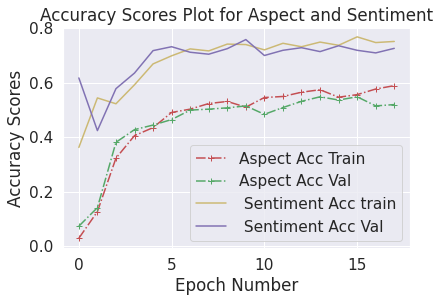

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


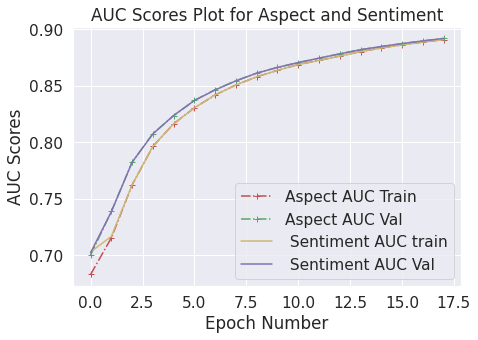

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


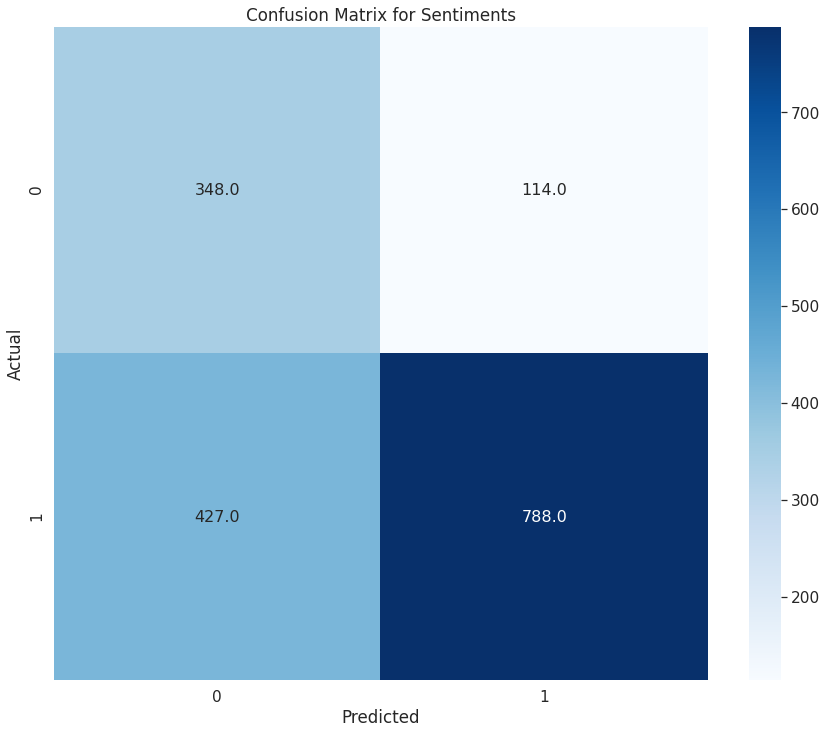

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


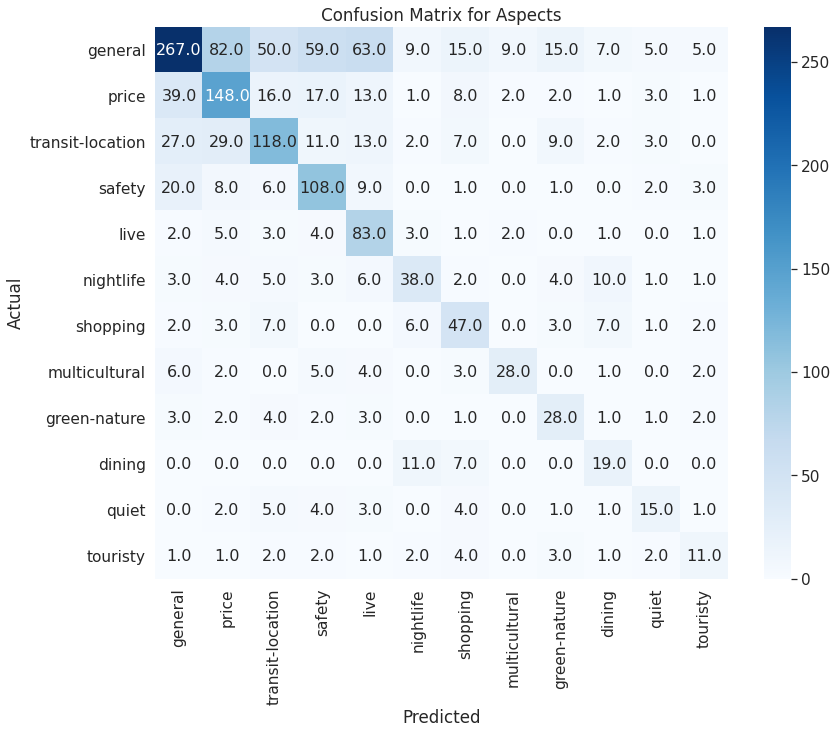

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide


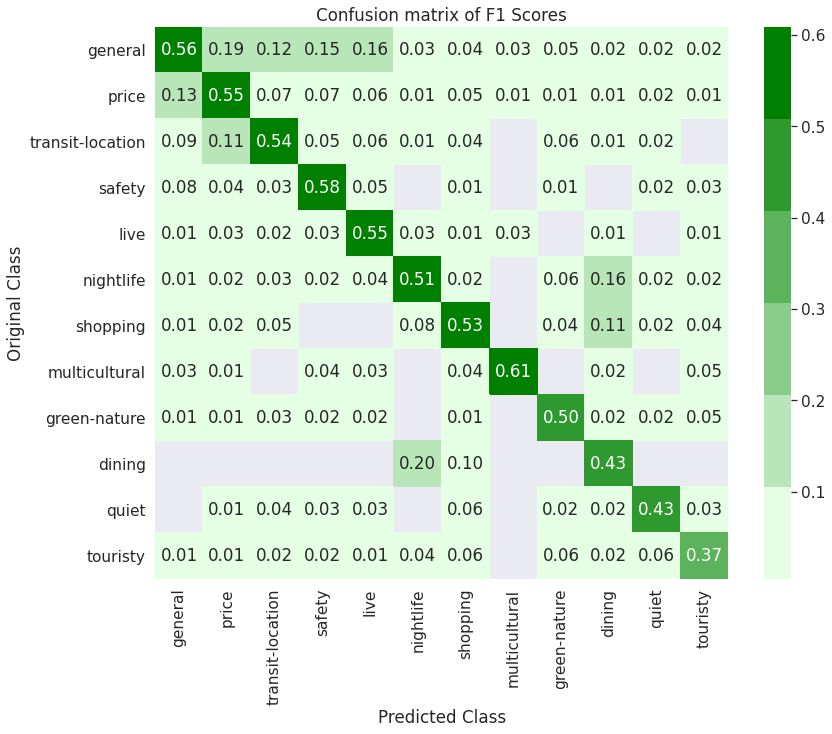

In [ ]:
preds_test, preds_val, preds_train, test_result_aspect, test_result_sentiment=essentials()
analyse_all()

## Model 10

In [ ]:
tf.keras.backend.clear_session()
embedded_layer = Embedding(2733,300,weights=[embedded],input_length=180,trainable=False)

input_text = Input(shape=(180,),name="input_text")
x_1 = embedded_layer(input_text)
# x_1 = LSTM(128, return_sequences=True)(x_1)
x_1=Bidirectional(LSTM(50, return_sequences=True))(x_1)
# flat_text=attention()(x_1)

flat_text = Flatten()(x_1)


input_location = Input(shape=(1,),name= "location")
layer_location = Embedding(2,1,trainable=False)(input_location)
flat_location = Flatten()(layer_location)


model = concatenate([flat_text ,flat_location])
# https://stackoverflow.com/questions/55181044/keras-custom-layer-valueerror-an-operation-has-none-for-gradient
# model = Dense(32,activation="relu",kernel_initializer="he_uniform")(model)
model = Dropout(0.001)(model)

outputs_aspect = Dense(12, activation='softmax', name="out_aspect")(model)   
outputs_sentiment = Dense(2, activation='softmax', name="out_sentiment")(model)

model = Model(inputs = [input_text , input_location  ],outputs=[outputs_aspect, outputs_sentiment])

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
checkpoint_filepath = '/tmp/checkpoint_10'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', save_best_only=True)

es=EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history=model.fit(train_req_x,{"out_aspect":y_train_aspect, "out_sentiment":y_train_sentiment}, 
                  validation_data=(val_req_x,{"out_aspect":y_val_aspect, "out_sentiment":y_val_sentiment}),
                  batch_size=150,epochs=40,verbose=1, callbacks=[model_checkpoint_callback, es], class_weight={"out_aspect":weights_aspect, "out_sentiment":weights_polarity})


Train on 3396 samples, validate on 838 samples
Epoch 1/40
3396/3396 [==============================] - 21s 6ms/step - loss: 11.2606 - out_aspect_loss: 10.2602 - out_sentiment_loss: 0.9620 - out_aspect_accuracy: 0.1961 - out_aspect_auc: 0.7087 - out_sentiment_accuracy: 0.5948 - out_sentiment_auc: 0.7226 - val_loss: 2.8449 - val_out_aspect_loss: 2.1960 - val_out_sentiment_loss: 0.6529 - val_out_aspect_accuracy: 0.3174 - val_out_aspect_auc: 0.7815 - val_out_sentiment_accuracy: 0.6408 - val_out_sentiment_auc: 0.7818
Epoch 2/40
3396/3396 [==============================] - 21s 6ms/step - loss: 8.6715 - out_aspect_loss: 7.8235 - out_sentiment_loss: 0.8406 - out_aspect_accuracy: 0.4385 - out_aspect_auc: 0.8162 - out_sentiment_accuracy: 0.7055 - out_sentiment_auc: 0.8162 - val_loss: 2.3730 - val_out_aspect_loss: 1.8084 - val_out_sentiment_loss: 0.5639 - val_out_aspect_accuracy: 0.4523 - val_out_aspect_auc: 0.8363 - val_out_sentiment_accuracy: 0.7232 - val_out_sentiment_auc: 0.8366
Epoch 3/40
33

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
-------------------- Sentiment --------------------
train Sentiment F1 :  0.8406949352179034
val Sentiment F1 :  0.7923627684964201
Test Sentiment F1 :  0.770423375074538
-------------------- Aspect --------------------
train Aspect F1 :  0.6617220251531764
val Aspect F1 :  0.5841650033266801
Test Aspect F1 :  0.5680672268907563
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


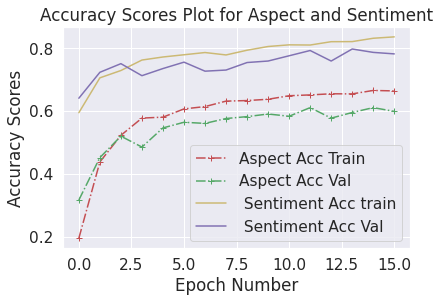

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


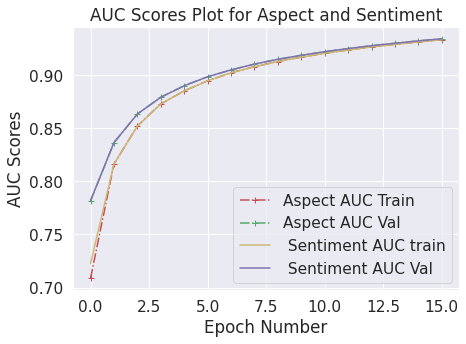

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


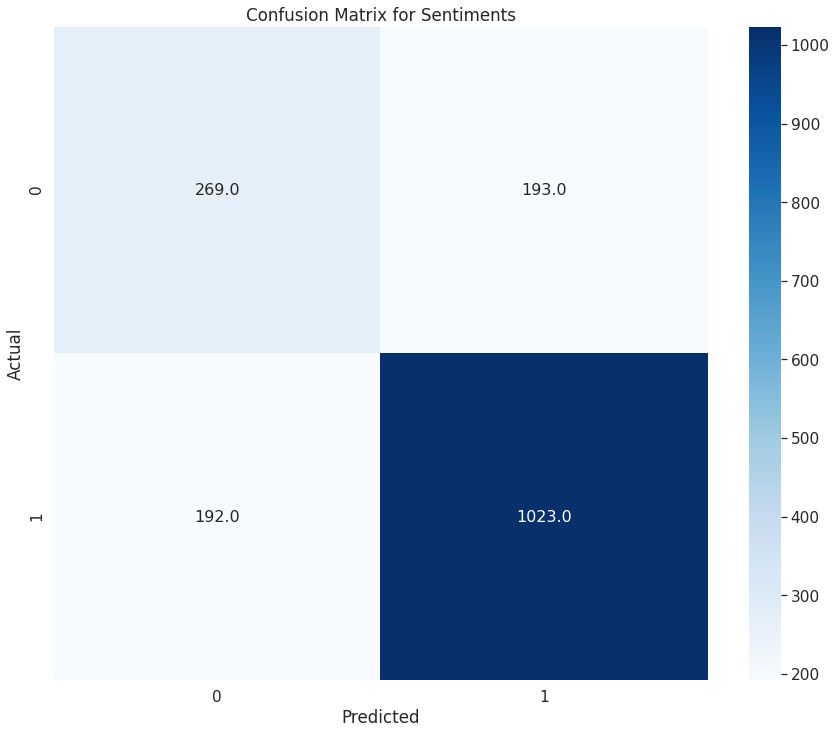

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


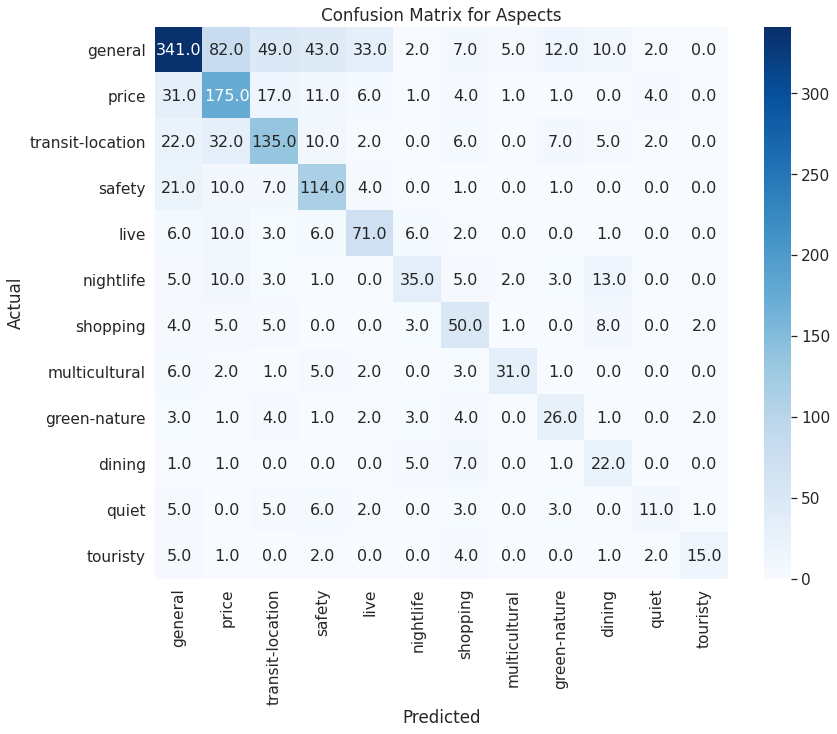

-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide


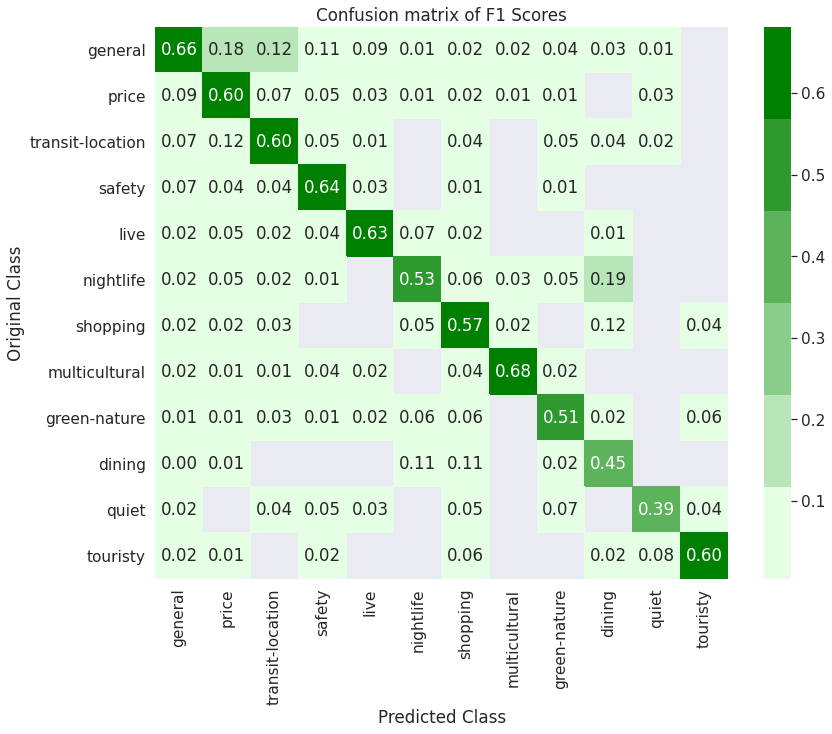

In [ ]:
preds_test, preds_val, preds_train, test_result_aspect, test_result_sentiment=essentials()
analyse_all()

In [ ]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model Number","Epochs", "LSTM Units","BiLSTM Units","Dense Units","Class-Weight", "Attention", "F1 Aspect", "F1 Sentiment", "AUC"]

x.add_row([ 1,24,"-" ,128,  32, "No", "No", 0.58, 0.79, 0.94])
x.add_row([ 2,18,"-" ,256,  32, "No", "No", 0.57, 0.79, 0.93])
x.add_row([ 3,23,"-" ,128,  32, "Yes", "No", 0.58, 0.78, 0.91])
x.add_row([ 4,27,"-" ,256,  32, "Yes", "No", 0.59, 0.76, 0.92])
x.add_row([ 5,24,128 ,"-",  32, "Yes", "No", 0.61, 0.76, 0.94])
x.add_row([ 6,13,256 ,"-",  32, "Yes", "No", 0.56, 0.77, 0.92])
x.add_row([ 7,29,128 ,"-",  32, "Yes", "Yes", 0.61, 0.75, 0.92])
x.add_row([ 8,23,"-" ,128,  32, "Yes", "Yes", 0.51, 0.72, 0.91])
x.add_row([ 9,18,"-" ,50,  "-", "Yes", "Yes", 0.31, 0.73, 0.90])
x.add_row([ 10,16,"-" ,128,  "-", "Yes", "Yes", 0.56, 0.76, 0.93])

print(x)

+--------------+--------+------------+--------------+-------------+--------------+-----------+-----------+--------------+------+
| Model Number | Epochs | LSTM Units | BiLSTM Units | Dense Units | Class-Weight | Attention | F1 Aspect | F1 Sentiment | AUC  |
+--------------+--------+------------+--------------+-------------+--------------+-----------+-----------+--------------+------+
|      1       |   24   |     -      |     128      |      32     |      No      |     No    |    0.58   |     0.79     | 0.94 |
|      2       |   18   |     -      |     256      |      32     |      No      |     No    |    0.57   |     0.79     | 0.93 |
|      3       |   23   |     -      |     128      |      32     |     Yes      |     No    |    0.58   |     0.78     | 0.91 |
|      4       |   27   |     -      |     256      |      32     |     Yes      |     No    |    0.59   |     0.76     | 0.92 |
|      5       |   24   |    128     |      -       |      32     |     Yes      |     No    |   

### Favourite Library

My favourite Library is Tensorflow. What I dislike about Tensorflow is the fact that It got updated last year and old codes got incompatible with the new version. This meant that the codes on open source websites, which included the implementations of many erstwhile State-of-the-art research papers became irrelevant. 
This proved to be an obstacle of many budding researchers, who needed to learn different versions of Tensorflow in short spans of time and forcing them to look for alternatives. This is how PyTorch gained widespread popularity in a very short span of time. 